# S1 Coursework

In [37]:
from scipy.stats import truncnorm, norm, crystalball, truncexpon, uniform
from scipy.stats import rv_continuous as rvs
from scipy.integrate import quad
import numpy as np
import matplotlib.pyplot as plt
import timeit
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL, ExtendedBinnedNLL
import scipy.stats as stats
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

Notifcation: Generation tools such as ChatGPT and Claude.ai were used to faciliate the code development in this section. Such tools are used for debugging code in the following sections: 1. using scipy.integrate when checking for normalistion of a joint model 2. the accept-reject model and vectorising it to enhance efficiency 3. fixing the loop for extracting lambda values and calculating lambda bias 4. optimising the parametric bootstrapping by parallelising the CPUs 5. formatting the histgoram plots for lambda bias, uncertainty and pull 6. Extracting the x samples from the bootstrapped data for sweights 7.writing the docker image

### Part B: Define a module

In [38]:
#g_s(X)
def signal_x_pdf(x, beta, m, mu, sigma):
    dist = stats.crystalball(beta=beta, m=m, loc=mu, scale=sigma)
    normalise=dist.cdf(5)-dist.cdf(0)
    return dist.pdf(x) / normalise

#h_s(Y)
def signal_y_pdf(y, lambda_val):
    dist = stats.truncexpon(b=10, scale=1 / lambda_val)
    normalise=dist.cdf(10)-dist.cdf(0)
    return dist.pdf(y) / normalise


#g_b(Y)
def background_x_pdf(x):
    return stats.uniform.pdf(x, loc=0, scale=5)

#h_b(X)
def background_y_pdf(y, mu_b, sigma_b):
    a = -mu_b / sigma_b
    b = (10 - mu_b) / sigma_b
    dist = stats.truncnorm(a=a, b=b, loc=mu_b, scale=sigma_b)
    return dist.pdf(y)

#s(X,Y)

def signal_pdf(x,y,beta,m,mu,sigma,lambda_val):
    return signal_x_pdf(x, beta, m, mu, sigma) * signal_y_pdf(y, lambda_val)

#b(X,Y)
def background_pdf(x,y,mu_b,sigma_b):
    return background_x_pdf(x) * background_y_pdf(y, mu_b, sigma_b)
    
    
#f(X,Y)
def joint_pdf(x, y, f, beta, m, mu, sigma, lambda_val, mu_b, sigma_b):
    return f * signal_pdf(x,y,beta,m,mu,sigma,lambda_val) + (1 - f) * background_pdf(x,y,mu_b,sigma_b)

To make sure that all my pdfs are normalised to 1 within the bounds of $ 𝑋 ∈ [0,5],𝑌 ∈ [0,10] $, I will perform numerical integration with the np.trapezoid method. I am using this over quad because it is less computationally expensive.

First I will check the normalisation to the parameter values provided in Equation 5. Then I will use three other sets of parameters to check whether normalisation works for other parameters too. 

In [39]:
# True parameter values
mu = 3.0    
sigma = 0.3   
beta = 1.0    
m = 1.4  
f = 0.6     
lambda_val = 0.3  
mu_b = 0.0  
sigma_b = 2.5

# X and Y ranges
x_range = np.linspace(0, 5, 1000)
y_range = np.linspace(0, 10, 1000)

# A meshgrid is needed for integrating over a 2-D space 
x_grid, y_grid = np.meshgrid(np.linspace(0, 5, 1000), np.linspace(0, 10, 1000))

In [40]:
#m>1,b>0

parameters = [
    {"mu": 3.0, "sigma": 0.3, "beta": 1.0, "m":1.4, "f": 0.6, "lambda_val": 0.3, "mu_b": 0.0, "sigma_b": 2.5},
    {"mu": 10.0, "sigma": 6.0, "beta": 5.0, "m":7.0, "f": 0.8, "lambda_val": 10, "mu_b": 6.0, "sigma_b": 5.0},
    {"mu": 6.0, "sigma": 0.6, "beta": 2.0, "m": 2.8, "f": 0.9, "lambda_val": 0.6, "mu_b": 1.0, "sigma_b": 5.0},
    {"mu": 1.5, "sigma": 0.15, "beta": 0.5, "m": 3.8, "f": 0.3, "lambda_val": 0.15, "mu_b": -1.0, "sigma_b": 1.25}
]

for i, params in enumerate(parameters):
    print(f"-----Test {i+1}----")
    
    # Integrate g_s(X)
    g_s_integral = integrate.trapezoid(signal_x_pdf(x_range, params["beta"], params["m"], params["mu"], params["sigma"]), x_range)
    print(f"g_s(X) integral: {g_s_integral:.6f}")
    
    # Integrate h_s(Y)
    h_s_integral = integrate.trapezoid(signal_y_pdf(y_range, params["lambda_val"]), y_range)
    print(f"h_s(Y) integral: {h_s_integral:.6f}")
    
    # Integrate g_b(X)
    g_b_integral = integrate.trapezoid(background_x_pdf(x_range), x_range)
    print(f"g_b(X) integral: {g_b_integral:.6f}")
    
    # Integrate h_b(Y)
    h_b_integral = integrate.trapezoid(background_y_pdf(y_range, params["mu_b"], params["sigma_b"]), y_range)
    print(f"h_b(Y) integral: {h_b_integral:.6f}")
    
    # Integrate s(X, Y)
    s_integral = integrate.trapezoid(
        integrate.trapezoid(signal_pdf(x_grid, y_grid, params["beta"], params["m"], params["mu"], params["sigma"], params["lambda_val"]), y_range, axis=1),
        x_range, axis=0
    )
    print(f"s(X, Y) integral: {s_integral:.6f}")
    
    # Integrate b(X, Y)
    b_integral = integrate.trapezoid(
        integrate.trapezoid(background_pdf(x_grid, y_grid, params["mu_b"], params["sigma_b"]), y_range, axis=1),
        x_range, axis=0
    )
    print(f"b(X, Y) integral: {b_integral:.6f}")
    
    # Integrate f(X, Y)
    f_integral = integrate.trapezoid(
        integrate.trapezoid(joint_pdf(x_grid, y_grid, params["f"], params["beta"], params["m"], params["mu"], params["sigma"], params["lambda_val"], params["mu_b"], params["sigma_b"]), y_range, axis=1),
        x_range, axis=0
    )
    print(f"f(X, Y) integral: {f_integral:.6f}")



-----Test 1----
g_s(X) integral: 1.000000
h_s(Y) integral: 1.000001
g_b(X) integral: 1.000000
h_b(Y) integral: 1.000000
s(X, Y) integral: 1.000001


KeyboardInterrupt: 

## Part C: Plotting 1-D X and Y

To plot the one dimensional projections of X and Y, I will first define my X and Y marginal pdfs.

In [6]:
# X PDF
def x_pdf(x, beta, m, mu, sigma,f):
    return f * signal_x_pdf(x, beta, m, mu, sigma) + (1-f) * background_x_pdf(x)

# Y PDF

def y_pdf(y, lambda_val, mu_b, sigma_b, f):
    return f * signal_y_pdf(y,lambda_val) + (1-f) * background_y_pdf(y,mu_b,sigma_b)

Now I can plot my figures

In [7]:
plt.figure(figsize=(12, 4))

# I will first plot the x signal, background and total marginal pdf
plt.subplot(121)
plt.plot(x_range, signal_x_pdf(x_range, beta, m, mu, sigma), label='Signal X')
plt.plot(x_range, background_x_pdf(x_range), label='Background X')
plt.plot(x_range, x_pdf(x_range, beta, m, mu, sigma,f),label = 'Total X')
plt.title('(a) X Distribution')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.legend()

# Then I will plot the y signal, background and total marginal pdf
plt.subplot(122)
plt.plot(y_range, signal_y_pdf(y_range, lambda_val), label='Signal Y')
plt.plot(y_range, background_y_pdf(y_range, mu_b, sigma_b), label='Background Y')
plt.plot(y_range, y_pdf(y_range, lambda_val, mu_b, sigma_b, f),label = 'Total Y')
plt.title('(b) Y Distribution')
plt.xlabel('Y')
plt.ylabel('Probability Density')
plt.legend()


In [8]:
# 2D Joint Distribution
z = joint_pdf(x_grid, y_grid, f, beta, m, mu, sigma, lambda_val, mu_b, sigma_b)

plt.contourf(x_grid, y_grid, z, levels=20, cmap='viridis')
plt.colorbar(label='Probability Density')
plt.title('Joint Distribution')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()

## Part D: Extended Maximum Likelihood fit

To sample from my distribution, I will use an accept-reject generator. To avoid high computational costs, I have precomputed the maximum value of my joint pdf evaluated for the given parameters, so I don't need to recalculate the maximum point everytime samples are generated.

In [9]:
def find_max(f, beta, m, mu, sigma, lambda_val, mu_b, sigma_b):
    
    # Evaluate the joint PDF on the grid
    joint_pdf_vals = joint_pdf(
        x=x_grid,
        y=y_grid,
        f=f,
        beta=beta,
        m=m,
        mu=mu,
        sigma=sigma,
        lambda_val=lambda_val,
        mu_b=mu_b,
        sigma_b=sigma_b
    )
    return np.max(joint_pdf_vals)


I will then define my accept reject generator.

In [10]:
def gen(mu, sigma, beta, m, f, lambda_val, mu_b, sigma_b, size, seed=5000):
    """
    Generate samples from the joint distribution using accept-reject sampling.
    """
    np.random.seed(seed)
    
    x_res, y_res = [], [] # my accepted x and y values
    
    max = find_max(f, beta, m, mu, sigma, lambda_val, mu_b, sigma_b)

    while len(x_res) < size: # As long as the length of my accepted x values is smaller than the size of sample I specified..
        x_proposals = np.random.uniform(0, 5, size=size) # propose a uniform batch of x values between 0 and 5, with a batch size of whatever size of sample I specified.
        y_proposals = np.random.uniform(0, 10, size=size) # same for values between 0 and 10 in y
        b_proposals = np.random.uniform(0, 1, size=size) # propose some value betwen 0 and 1, because that is where my joint pdf is defined.

        # for any x and y point that is randomly generated evaluated with the parameters given, give a joint pdf output!
        joint_pdf_vals = joint_pdf(
            x=x_proposals,
            y=y_proposals,
            f=f,
            beta=beta,
            m=m,
            mu=mu,
            sigma=sigma,
            lambda_val=lambda_val,
            mu_b=mu_b,
            sigma_b=sigma_b
        )

        # b_proposal * max basically generates a random point within a rectangle that encloses my joint pdf
        # if the point generated is below the evaluated joint pdf, then accept.
        accepted = b_proposals * max <= joint_pdf_vals
        x_res.extend(x_proposals[accepted])
        y_res.extend(y_proposals[accepted])

    # Ensure the output arrays have exactly `size` elements
    return np.array(x_res[:size]), np.array(y_res[:size])

and now I will generate my sample of 100,000 points using the given parameters.

In [11]:
samples=gen(mu=mu,sigma=sigma, beta=beta, m=m, f=f, lambda_val=lambda_val, mu_b=mu_b, sigma_b=sigma_b, size=100000,seed=2304)

let me check whether the generated samples matches the expected distribution.

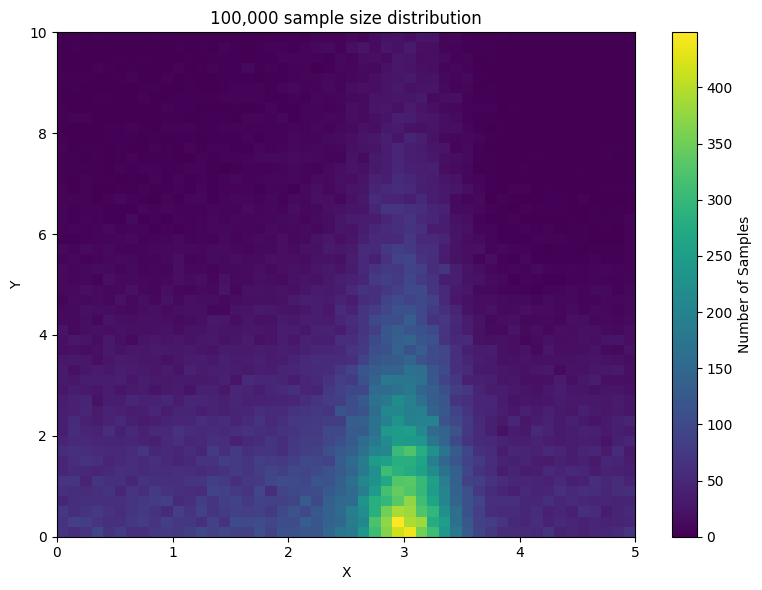

In [12]:
# Assuming samples is your generated data
x_samples, y_samples = samples[0], samples[1]

plt.figure(figsize=(8, 6))

hist = plt.hist2d(x_samples, y_samples, 
                  bins=(50, 50), 
                  cmap='viridis',
                  range=[[0, 5], [0, 10]]) 


plt.colorbar(hist[3], label='Number of Samples')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('100,000 sample size distribution')
plt.tight_layout()
plt.show()

Now that I have generated my samples, I want to do a EML. I am restating all of the functions within density to make it run faster. After that, I am using iminuit to run the EML.

In [13]:
def density(data, n, f, mu, sigma, beta, m, lambda_val, mu_b, sigma_b):
    
    X, Y = data

    # x signal
    x_signal = crystalball.pdf(X, beta, m, mu, sigma) / (crystalball.cdf(5.0, beta, m, mu, sigma) - crystalball.cdf(0.0, beta, m, mu, sigma))
    
    # y signal 
    
     # #Using explicit equation with np becasue stats.truncexpon runs slower
    y_norm = max(1 - np.exp(-10 * lambda_val), 1e-10)  # Avoid division by zero
    y_signal = (lambda_val * np.exp(-lambda_val * Y)) / y_norm

    # x background
    x_back = np.zeros_like(X)  # Initialize with zeros
    x_back[(X >= 0) & (X <= 5)] = 1 / 5.0  # Assign 1/5 where X is in the range [0, 5]

    # y background 
    y_norm_back = max(norm.cdf(10, mu_b, sigma_b) - norm.cdf(0, mu_b, sigma_b), 1e-10) #safeguarding the normalisation factor in case it gets too small
    y_back = (1 / (sigma_b * np.sqrt(2 * np.pi))) * np.exp(-(Y - mu_b)**2 / (2 * sigma_b**2))
    y_back = y_back / y_norm_back

    # Combine signal and background
    
    joint= f * (x_signal * y_signal) + (1-f) * (x_back * y_back)

    return n, n * joint

In [14]:
# Set up Minuit

def eml(data,density):
    c = ExtendedUnbinnedNLL(data, density)
    mi = Minuit(
        c,
        n=100000,       
        f=0.6,         
        mu=3,          
        sigma=0.3,     
        beta=1.0,     
        m=1.4, 
        lambda_val=0.3, 
        mu_b=0,   
        sigma_b=2.5  
    )
    
    mi.limits['beta'] = (0.0001, 5)         # Enforce beta > 1.0
    mi.limits['lambda_val'] = (0.01, 2.0)
    mi.limits['sigma_b'] = (0.1, 10.0)
    mi.limits['m'] = (1.00000001, None)


    mi.strategy = 2

    mi.migrad() 
    mi.hesse()

    return mi

In [15]:
eml(samples,density)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.46e+06                  │              Nfcn = 327              │
│ EDM = 2.61e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name       │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n          │ 100.00e3  │  0.32e3   │            │            │         │         │       │
│ 1 │ f          │   0.598   │   0.004   │            │            │         │         │       │
│ 2 │ mu         │  2.9960   │  0.0026   │            │            │         │         │       │
│ 3 │ sigma      │  0.3038   │  0.0024   │            │            │         │         │       │
│ 4 │ beta       │   1.032   │   0.023   │            │            │ 0.0001  │    5    │       │
│ 5 │ m          │   1.35    │   0.06    │            │            │    1    │         │       │
│ 6 │ lambda_val │  0.2996   │  0.0021   │            │            │  0.01   │    2    │       │
│ 7 │ mu_b       │   0.03    │   0.08    │            │            │         │         │       │
│ 8 │ sigma_b    │   2.49    │   0.04    │            │            │   0.1   │   10    │       │
└───┴────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────┐
│            │          n          f         mu      sigma       beta          m lambda_val       mu_b    sigma_b │
├────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────┤
│          n │   1.01e+05  -2.496e-3   1.331e-3  -1.650e-3   -18.6e-3      0.049    -825e-6     -0.052     0.0238 │
│          f │  -2.496e-3    1.3e-05      -0e-6       3e-6   0.010e-3  -0.088e-3       2e-6   0.058e-3  -0.033e-3 │
│         mu │   1.331e-3      -0e-6   6.61e-06      -3e-6     -30e-6      55e-6      -0e-6      -3e-6       2e-6 │
│      sigma │  -1.650e-3       3e-6      -3e-6   6.01e-06      26e-6     -54e-6       0e-6      19e-6     -11e-6 │
│       beta │   -18.6e-3   0.010e-3     -30e-6      26e-6   0.000546    -1.3e-3       1e-6     0.1e-3    -0.1e-3 │
│          m │      0.049  -0.088e-3      55e-6     -54e-6    -1.3e-3    0.00399     -13e-6     -0.001     0.0004 │
│ lambda_val │    -825e-6       2e-6      -0e-6       0e-6       1e-6     -13e-6   4.27e-06      10e-6       4e-6 │
│       mu_b │     -0.052   0.058e-3      -3e-6      19e-6     0.1e-3     -0.001      10e-6    0.00658    -0.0029 │
│    sigma_b │     0.0238  -0.033e-3       2e-6     -11e-6    -0.1e-3     0.0004       4e-6    -0.0029    0.00145 │
└────────────┴────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [16]:
import timeit

def time_bench():
    return np.random.normal(size=100000)

def time_gen():
    return gen(
        mu=mu, 
        sigma=sigma, 
        beta=beta, 
        m=m, 
        f=f, 
        lambda_val=lambda_val, 
        mu_b=mu_b, 
        sigma_b=sigma_b, 
        size=100000
    )
    
def time_minuit():
    return eml(data=samples,density=density)
    

benchmark_t = timeit.repeat(
    time_bench, 
    repeat=100,
    number=1
)

generator_t = timeit.repeat(
    time_gen, 
    repeat=100,
    number=1
)

eml_t = timeit.repeat(
    time_gen, 
    repeat=100,
    number=1
)

bench_avg = np.mean(benchmark_t)
gen_avg = np.mean(generator_t)
eml_avg = np.mean(eml_t)

gen_speed=gen_avg/bench_avg
eml_speed=eml_avg/bench_avg

print(f"Generating 100,000 samples using the accept reject method is {gen_speed} times slower than using numpy to randomly sample 100,000 points")
print(f"Fitting 100,000 samples using EML is {eml_speed} times slower than using numpy to randomly sample 100,000 points")

Generating 100,000 samples using the accept reject method is 369.24638624311376 times slower than using numpy to randomly sample 100,000 points
Fitting 100,000 samples using EML is 277.7129841896834 times slower than using numpy to randomly sample 100,000 points


## Part E: Parametric bootstrapping and determining bias

In [17]:
import uncertainties as uncert 

N_sample = [500, 1000, 2500, 5000, 10000]
param_names = ['f', '\mu', '\sigma', '\\beta', 'm', '\lambda_val', '\mu_b', '\sigma_b']
fitted_values = [0.598, 2.9960, 0.3038, 1.032, 1.35, 0.2996, 0.03, 2.49]
f, mu, sigma, beta, m, lambda_val, mu_b, sigma_b = fitted_values # I am overwriting my pre-existing parameter values into my new EML ones from part d.

To begin, I will create a new accept-reject generator to include a poisson varying sample size. And I will list the number of sample sizes, parameter names, and the fitted parameter values from my EML parameter estimation.

In [18]:
def poisson_gen(mu, sigma, beta, m, f, lambda_val, mu_b, sigma_b, size, seed=1):
 
    np.random.seed(seed)
    psize=np.random.poisson(size)
    x_res, y_res = [], []

    ymax = find_max(f, beta, m, mu, sigma, lambda_val, mu_b, sigma_b)
    
    while len(x_res) < psize:
        # Propose samples
        x_proposals = np.random.uniform(0, 5, size=psize)
        y_proposals = np.random.uniform(0, 10, size=psize)
        b_proposals = np.random.uniform(0, 1, size=psize)


        joint_pdf_vals = joint_pdf(
            x=x_proposals,
            y=y_proposals,
            f=f,
            beta=beta,
            m=m,
            mu=mu,
            sigma=sigma,
            lambda_val=lambda_val,
            mu_b=mu_b,
            sigma_b=sigma_b
        )

        accepted = b_proposals * ymax <= joint_pdf_vals
        x_res.extend(x_proposals[accepted])
        y_res.extend(y_proposals[accepted])

    return np.array(x_res[:psize]), np.array(y_res[:psize])

This is a big sample size to generate. I will parallelize it for faster computation, so I am running tasks across all my CPUs.

In [19]:
from joblib import Parallel, delayed

def generate_toys(N_sample, Ntoy=250):
    np.random.seed(2304) 
    seeds = np.random.randint(0, 2**20, size=Ntoy) #making a random seed for each toy
    toys = Parallel(n_jobs=-1)(
        delayed(poisson_gen)(
            mu=mu, sigma=sigma, beta=beta, m=m, f=f, 
            lambda_val=lambda_val, mu_b=mu_b, sigma_b=sigma_b, 
            size=N_sample, seed=seed
        )
        for seed in tqdm(seeds, desc=f'Generating {Ntoy} toys with N={N_sample}')
    )
    return toys

In [20]:
toys = {}

for sample in N_sample:
    toys[sample] = generate_toys(sample, Ntoy=250)

Generating 250 toys with N=10000: 100%|██████████| 250/250 [01:08<00:00,  3.63it/s]


I would like to inspect my toys to see if they outputted the correct things: 

In [21]:
for key, value in toys.items():
    print(f"Key {key}:")
    print(f"  Number of toys: {len(value)}")
    print(f"  Type of first toy: {type(value[0])}")
    # If the toys are numpy arrays, you can check their shape
    print(f"  Shape of first toy's x: {value[0][0].shape}")
    print(f"  Shape of first toy's y: {value[0][1].shape}")

Key 500:
  Number of toys: 250
  Type of first toy: <class 'tuple'>
  Shape of first toy's x: (514,)
  Shape of first toy's y: (514,)
Key 1000:
  Number of toys: 250
  Type of first toy: <class 'tuple'>
  Shape of first toy's x: (1020,)
  Shape of first toy's y: (1020,)
Key 2500:
  Number of toys: 250
  Type of first toy: <class 'tuple'>
  Shape of first toy's x: (2388,)
  Shape of first toy's y: (2388,)
Key 5000:
  Number of toys: 250
  Type of first toy: <class 'tuple'>
  Shape of first toy's x: (4841,)
  Shape of first toy's y: (4841,)
Key 10000:
  Number of toys: 250
  Type of first toy: <class 'tuple'>
  Shape of first toy's x: (9775,)
  Shape of first toy's y: (9775,)


I will now define a function for me to fit the data. Note that I included N_sample as a parameter because I am wanting to fit for many sample sizes. After fitting the data, I will want to take the estimated parameters to plot their mean, uncertainty and pull. I will define a plot function too.

In [22]:
def fit_model(data, N_sample):
    X, Y = data
    nll = ExtendedUnbinnedNLL((X,Y), density)
    mi = Minuit(nll, 
            n=N_sample,
            f=fitted_values[0], 
            mu=fitted_values[1], 
            sigma=fitted_values[2], 
            beta=fitted_values[3], 
            m=fitted_values[4], 
            lambda_val=fitted_values[5], 
            mu_b=fitted_values[6], 
            sigma_b=fitted_values[7])
    mi.limits["n"] = (0, None)
    mi.limits["beta"] = (0.01, 10)
    mi.limits["m"] = (1.01, 10)
    mi.limits['sigma'] = (0,None)
    mi.limits['sigma_b'] = (1e-3, None)
    mi.limits['lambda_val'] = (1e-3, 2)
    mi.limits['f'] = (0, 1)

    mi.migrad()
    mi.hesse()

    return mi 

In [23]:
def plot(xvals , ax=None):
    ax = ax or plt.gca()
    # compute mean, sdev and their errors of distribution
    m = np.mean(xvals)
    s = np.std(xvals , ddof=1)
    me = s/len(xvals)**0.5
    se = s/(2*len(xvals)-1)**0.5
    # make a density histogram
    nh, xe = np.histogram( xvals, range=(m-3*s,m+3*s), bins='auto', density= True )
    # draw the density histogram
    ax.hist( xvals, bins=xe, density=True, alpha=0.5 )
    # also draw error bars on points
    N = np.sum(nh)/len(xvals)
    cx = 0.5*(xe[1:]+xe[:-1])
    ax.errorbar( cx, nh, N*(nh/N)**0.5, fmt='ko' )
    # draw the normal distribution with the mean and sigma
    x = np.linspace(xe[0],xe[-1],100)
    ax.plot(x, norm.pdf(x,m,s), 'r-')
    # plot the results (use uncertainties package for nice formatting)
    um = uncert.ufloat( m, me )
    us = uncert.ufloat( s, se )
    mstr = f"{um:.1u}".replace("+/-","\pm")
    sstr = f"{us:.1u}".replace("+/-","\pm")
    ax.text(0.01,0.92, f"$\hat{{\mu}} = {mstr}$", transform=ax.transAxes) 
    ax.text(0.01,0.86, f"$\hat{{\sigma}} = {sstr}$", transform=ax.transAxes)

In [24]:
values = {}
errors = {}
pulls = {}

# Fixed truth values for all other parameters
truth_fixed = np.array([0.598, 2.9960, 0.3038, 1.032, 1.35, 0.2996, 0.03, 2.49])

for size in N_sample:
    sample_values = []
    sample_errors = []
    sample_pulls = []

    for toy in tqdm(toys[size], desc=f"Processing toys for N_sample={size}"):
        # Dynamically determine 'n' for the current toy
        n_actual = len(toy[0])  # Length of x_res (x-array)
        
        # Fit the model
        mi_t = fit_model(toy, N_sample=size)
        sample_values.append(list(mi_t.values))
        sample_errors.append(list(mi_t.errors))

        # Construct dynamic truth by adding n_actual to the fixed truth
        truth_dynamic = np.insert(truth_fixed, 0, n_actual)  # Insert n_actual at position 0
        #or i could just do mi_t.values - mi.values / mi_t.errors

        # Compute pulls
        pull = (np.array(list(mi_t.values)) - truth_dynamic) / np.array(list(mi_t.errors))
        sample_pulls.append(pull)

    # Store results
    values[size] = np.array(sample_values)
    errors[size] = np.array(sample_errors)
    pulls[size] = np.array(sample_pulls)


Processing toys for N_sample=500:   0%|          | 0/250 [00:00<?, ?it/s]

Processing toys for N_sample=10000: 100%|██████████| 250/250 [07:46<00:00,  1.86s/it]


I have calculated the estimate, pull and error for ALL my parameters because I want to check through that lambda is not super dependent on another parameter. I have included the plots of all these in the appendix, and I will talk thorugh this briefly in the report. But from these values I want to extract lambda only, and I have done that here:

In [25]:
# Dictionaries to store results specifically for lambda
lambda_values = {}
lambda_errors = {}
lambda_pulls = {}

# Extract only the `lambda_val` parameter for each sample size
for N_sample, sample_values in values.items():
    param_names = ['n', 'f', 'mu', 'sigma', 'beta', 'm', 'lambda_val', 'mu_b', 'sigma_b']
    lambda_index = param_names.index('lambda_val')  # Get the index for 'lambda_val'

    # Extract `lambda_val` and corresponding errors/pulls
    lambda_values[N_sample] = sample_values[:, lambda_index]
    print(f"Lambda values for key {N_sample} (first 10):", lambda_values[N_sample][:10])

    lambda_errors[N_sample] = errors[N_sample][:, lambda_index]
    lambda_pulls[N_sample] = pulls[N_sample][:, lambda_index]

Lambda values for key 500 (first 10): [0.32920436 0.30711085 0.31565699 0.30074808 0.33792025 0.27979022
 0.35593817 0.3610362  0.27686622 0.30864522]
Lambda values for key 1000 (first 10): [0.30464382 0.25586453 0.3082117  0.31074445 0.311375   0.28848858
 0.32465006 0.31228476 0.34676774 0.3052874 ]
Lambda values for key 2500 (first 10): [0.29764355 0.30247662 0.280438   0.30397512 0.30695923 0.30517996
 0.28353877 0.29214484 0.31978252 0.29538038]
Lambda values for key 5000 (first 10): [0.32109345 0.27654683 0.29046604 0.29945091 0.28548196 0.29567523
 0.28838    0.29203078 0.2978119  0.29165855]
Lambda values for key 10000 (first 10): [0.29899528 0.2947372  0.29208379 0.29542111 0.29974022 0.29962734
 0.30365439 0.29957182 0.2953219  0.29678407]


Calculating the lambda bias:

In [26]:
true_lambda = 0.2996

lambda_bias = {}

for N_sample, sample_lambda_values in lambda_values.items():
    lambda_bias[N_sample] = sample_lambda_values - true_lambda  

Plotting the values, pulls, bias and uncertainty in histograms:

In [27]:
# Create a figure with 2 columns (bias and uncertainty) and as many rows as keys
n_keys = len(lambda_bias)
fig, axes = plt.subplots(n_keys, 3, figsize=(14, 3 * n_keys), sharey=False)

# Loop through keys and plot bias (column 0) and uncertainty (column 1)
for i, key in enumerate(lambda_bias.keys()):
    
    # Estimates plot in the first column
    plot(lambda_values[key], ax=axes[i, 0])
    axes[i, 0].set_title(f"Estimates for Sample size={key}")
    axes[i, 0].set_xlabel("Estimate")
    axes[i, 0].set_ylabel("Density")
    
    # Uncertainty plot in the second column
    plot(lambda_errors[key], ax=axes[i, 1])
    axes[i, 1].set_title(f"Uncertainty for Sample size={key}")
    axes[i, 1].set_xlabel("Uncertainty")
    axes[i, 1].set_ylabel("Density")
    
    # Estimates plot in the first column
    plot(lambda_pulls[key], ax=axes[i, 2])
    axes[i, 2].set_title(f"Pulls for Sample size={key}")
    axes[i, 2].set_xlabel("Pulls")
    axes[i, 2].set_ylabel("Density")


# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Now I want to see the mean bias and uncertainty across sample sizes, as a scatter plot:

In [28]:

keys = []
mean_lambdas = []
std_lambdas = []
mean_errors = []
std_errors = []
mean_bias=[]
std_bias=[]


for key in lambda_values.keys():
    lambdas1 = lambda_values[key]
    errors1 = lambda_errors[key]
    bias1 = lambda_bias[key]


    mean_lambda = np.mean(lambdas1)
    std_lambda = np.std(lambdas1, ddof=1) / np.sqrt(key)  # Adjusted for sqrt(N)

    mean_error = np.mean(errors1)
    std_error = np.std(errors1, ddof=1) / np.sqrt(key)  # Adjusted for sqrt(N)
    
    mean_bias_vals = np.mean(bias1)
    std_bias_vals = np.std(bias1, ddof=1) / np.sqrt(key)  # Adjusted for sqrt(N)

    keys.append(key)
    mean_lambdas.append(mean_lambda)
    std_lambdas.append(std_lambda)
    mean_errors.append(mean_error)
    std_errors.append(std_error)
    mean_bias.append(mean_bias_vals)
    std_bias.append(std_bias_vals)


# I want to plot my mean values with standard deviation as error bars
keys = np.array(keys)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

axes[0].errorbar(keys, mean_lambdas, yerr=std_lambdas, fmt='o-', label='Mean Lambda Values', capsize=5)
axes[0].set_xlabel('Sample Size (Key)')
axes[0].set_ylabel('Mean Lambda Value')
axes[0].set_title('a) Mean Lambda Value vs. Sample Size')
axes[0].grid(True)
axes[0].legend()

axes[1].errorbar(keys, mean_bias, yerr=std_bias, fmt='o-', label='Mean Lambda Bias', capsize=5)
axes[1].axhline(0, color='red', linestyle='--', label='Zero Bias (Reference)')
axes[1].set_xlabel('Sample Size (Key)')
axes[1].set_ylabel('Mean Lambda Bias')
axes[1].set_title('b) Mean Lambda Bias vs. Sample Size')
axes[1].grid(True)
axes[1].legend()

axes[2].errorbar(keys, mean_errors, yerr=std_errors, fmt='o-', label='Mean Lambda Uncertainties', capsize=5)
axes[2].set_xlabel('Sample Size (Key)')
axes[2].set_ylabel('Mean Lambda Uncertainty')
axes[2].set_title('c) Mean Lambda Uncertainty vs. Sample Size')
axes[2].grid(True)
axes[2].legend()


# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### error: instead of doing standard deviation, i shoulld square root and divdie by N

## Part F: Peform an EML fit in variable X and use sWeights!

In [29]:
from types import SimpleNamespace

# external requirements
import numpy as np
from scipy.stats import norm, expon
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL

# from this package
from sweights import SWeight # for classic sweights
from sweights import Cow     # for custom orthogonal weight functions
from sweights import cov_correct, approx_cov_correct # for covariance corrections
from sweights.testing import make_classic_toy # to generate a toy dataset
from sweights.util import plot_binned, make_weighted_negative_log_likelihood

In [30]:
# Initialize a dictionary to store all x arrays by key
x_arrays_dict = {}

# Loop through all keys in the original dictionary
for key in toys:
    # Extract the list of tuples for the current key
    arrays = toys[key]
    
    # Extract the x arrays (first element of each tuple)
    x_arrays = [x for x, y in arrays]
    
    # Assign the list of x arrays to the corresponding key
    x_arrays_dict[key] = x_arrays
    
# Initialize a dictionary to store all x arrays by key
y_arrays_dict = {}

# Loop through all keys in the original dictionary
for key in toys:
    # Extract the list of tuples for the current key
    arrays = toys[key]
    
    # Extract the x arrays (first element of each tuple)
    y_arrays = [y for x, y in arrays]
    
    # Assign the list of x arrays to the corresponding key
    y_arrays_dict[key] = y_arrays

In [31]:
def tdensity(x, Ns, Nb, beta, m, mu, sigma):
    total_pdf = Ns * signal_x_pdf(x, beta, m, mu, sigma) + Nb * background_x_pdf(x)
    return Ns + Nb, total_pdf

In [32]:
param_names = ['f', '\mu', '\sigma', '\\beta', 'm', '\lambda_val', '\mu_b', '\sigma_b']
fitted_values = [0.598, 2.9960, 0.3038, 1.032, 1.35, 0.2996, 0.03, 2.49]

N_sample = [500, 1000, 2500, 5000, 10000]

save_s_weights={}

for s in N_sample:
    
    save_s_weights[s] = []
    
    for i in tqdm(range(len(x_arrays_dict[s])),desc="Sweight calculating"):
        
        x_values = x_arrays_dict[s][i]
        n211 = ExtendedUnbinnedNLL(x_values, tdensity)
        mi3 = Minuit(n211,
                    Ns=0.6*len(x_values),
                    Nb=0.4*len(x_values),
                    mu=2.9980, 
                    sigma=0.3038,
                    beta=1.032, 
                    m=1.35)
        
        mi3.limits ["m"] = (1, None)
        mi3.limits ['beta'] = (0, None)
        mi3.limits ["Ns"] = (1e-3, None)
        mi3.limits ["Nb"] = (1e-3, None)
        mi3.limits ['sigma'] = (1e-6, None)
        
        mi3.migrad ()
        mi3. hesse ()
        
        sf = lambda x: signal_x_pdf(x, mi3.values['beta'], mi3.values['m'], mi3.values['mu'], mi3.values['sigma'])
        bf = lambda x: background_x_pdf(x)
        sy = mi3.values['Ns']
        by = mi3.values['Nb']
        
        # Create Sweight with the full dataset
        sweighter = SWeight(x_values,
        pdfs=[sf, bf],
        yields= [sy,by],
        discvarranges=((0, 5),), checks=False)
                                                
        save_s_weights[s].append(sweighter)

Sweight calculating:   3%|▎         | 8/250 [00:13<08:35,  2.13s/it]/Users/Jasthecoolbean/Desktop/cw/S1/jn492/s1venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:11118: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/Users/Jasthecoolbean/Desktop/cw/S1/jn492/s1venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:11118: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/Users/Jasthecoolbean/Desktop/cw/S1/jn492/s1venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:11086: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/Users/Jasthecoolbean/Desktop/cw/S1/jn492/s1venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:11086: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/var/folders/9l/2p8y7fsj3vx7zmgnjbtt1jb40000gn/T/ipykernel_40695

In [33]:
yrange=(0,10)
def truncated_exponential(y, lambd, n):
    cdf=truncexpon.cdf(y,b=10,loc=0,scale=1/lambd)
    return n * cdf

# Initialize results
result_opt = {}
result_cov= {}

# Loop over sample sizes
for s in N_sample:
    result_opt[s] = []
    result_cov[s] = []

    # Loop over entries in y_dict for current sample size
    for i in tqdm(range(len(y_arrays_dict[s]))):
        # Extract x and y values
        x_values = x_arrays_dict[s][i]
        y_values = y_arrays_dict[s][i]

        # Get weights
        sweighter = save_s_weights[s][i]
        sw = sweighter.get_weight(0, x_values)
        bw = sweighter.get_weight(1, x_values)

        # Create histogram
        ysw, ye = np.histogram(y_values, bins=50, range=yrange, weights=sw)
        total_events = sum(ysw)

        # Create and run fit
        nll = ExtendedBinnedNLL(ysw, ye, truncated_exponential)
        m = Minuit(nll, lambd=0.2996, n=total_events)
        m.limits["lambd"] = (1e-6, None)
        m.strategy = 2
        m.migrad()
        m.hesse()

        # Store results
        result_opt[s].append(m.values["lambd"])
        result_cov[s].append(m.errors["lambd"])

# Print results
print("Optimization Results:", result_opt)
print("Covariance Results:", result_cov)

print(result_opt[10000])


100%|██████████| 250/250 [00:06<00:00, 41.44it/s]

Optimization Results: {500: [0.30425054306061106, 0.2879415435389665, 0.29934823979475833, 0.29335542553926264, 0.3341144639882592, 0.2476103465706421, 0.3396453639740744, 0.36879372972819907, 0.3026430460378894, 0.31021056551063586, 0.2862761214543393, 0.35551864635596614, 0.29864495887925974, 0.25216155325830913, 0.24390717087238264, 0.339096150702253, 0.2879248956267166, 0.26530331930892037, 0.3393006340764112, 0.25243968267692235, 0.34532232533372886, 0.28861925912514796, 0.3205863975404888, 0.257428683793822, 0.29513761612466344, 0.31440085788255673, 0.3148771596829514, 0.28120769023955644, 0.2908014816150977, 0.28663273050304816, 0.3027322957020914, 0.3161973322675631, 0.3381449114091706, 0.34965420133019964, 0.2612638817324406, 0.3321528776121088, 0.23476807071631417, 0.29699636374471955, 0.3605391622490862, 0.3241022860831444, 0.29129467614123783, 0.2993479513733775, 0.3382597110189695, 0.27064742739220593, 0.29967866623683326, 0.3457074467783843, 0.302800107736966, 0.345981818

In [34]:
print(result_opt.keys())

dict_keys([500, 1000, 2500, 5000, 10000])


In [61]:
lambda_true = 0.2996

bias_lambda=[]
error_bar=[]

uncertainty_lambda=[]
error_for_uncertainty=[]

for i in N_sample:
    lambda_est = np.mean(result_opt[i])
    bias_lambda.append(lambda_est-lambda_true)
    error_bar.append((np.std(result_opt[i]))/np.sqrt(i))

    weight_error=np.mean(result_cov[i])
    uncertainty_lambda.append(weight_error)
    error_for_uncertainty.append(np.std(result_cov[i])/np.sqrt(i))

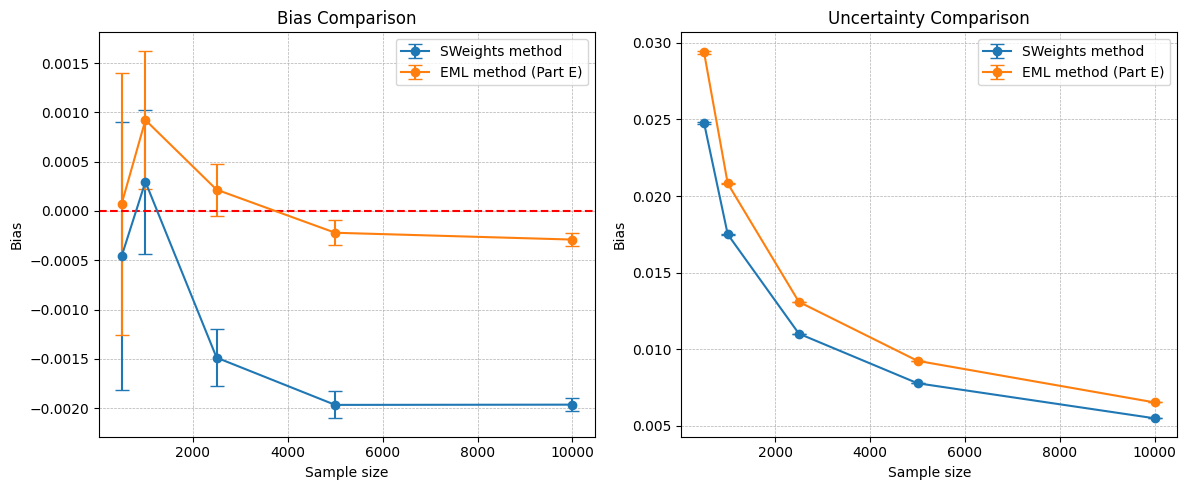

In [64]:
coefficients = np.polyfit(np.log(N_sample), bias_lambda, 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].errorbar(N_sample, bias_lambda, yerr=error_bar, fmt='o-', label='SWeights method', capsize=5)
axes[0].errorbar(keys, mean_bias, yerr=std_bias, fmt='o-', label='EML method (Part E)', capsize=5)
axes[0].set_title('Bias Comparison')
axes[0].set_xlabel('Sample size')
axes[0].set_ylabel('Bias')
axes[0].legend()
axes[0].grid(which='both', linestyle='--', linewidth=0.5)
axes[0].axhline(0, color='red', linestyle='--', label='Zero Bias (Reference)')

axes[1].errorbar(N_sample, uncertainty_lambda, yerr=error_for_uncertainty, fmt='o-', label='SWeights method', capsize=5)
axes[1].errorbar(keys, mean_errors, yerr=std_errors, fmt='o-', label='EML method (Part E)', capsize=5)
axes[1].set_title('Uncertainty Comparison')
axes[1].set_xlabel('Sample size')
axes[1].set_ylabel('Bias')
axes[1].legend()
axes[1].grid(which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


In [ ]:
def tdensity(x, Ns, Nb, beta, m, mu, sigma):
    total_pdf = Ns * signal_x_pdf(x, beta, m, mu, sigma) + Nb * background_x_pdf(x)
    return Ns + Nb, total_pdf

### Extra example to show the plots of sWeights for the report

Example for how sWeights work for a single toy, specifically the first toy of the 5000 sample size:

In [42]:
n3ll = ExtendedUnbinnedNLL(x_arrays_dict[5000][0], tdensity)
miplot = Minuit(n3ll,
                Ns=0.6*len(x_values),
                Nb=0.4*len(x_values),
                mu=2.9980, 
                sigma=0.3038,
                beta=1.032, 
                m=1.35)

miplot.limits ["m"] = (1, None)
miplot.limits ['beta'] = (0, None)
miplot.limits ["Ns"] = (1e-3, None)
miplot.limits ["Nb"] = (1e-3, None)
miplot.limits ['sigma'] = (1e-6, None)

miplot.migrad()
miplot.hesse()
display(miplot)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -5.954e+04                 │              Nfcn = 256              │
│ EDM = 8.64e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Ns    │  2.98e3   │  0.10e3   │            │            │  0.001  │         │       │
│ 1 │ Nb    │  1.87e3   │  0.09e3   │            │            │  0.001  │         │       │
│ 2 │ beta  │   0.93    │   0.10    │            │            │    0    │         │       │
│ 3 │ m     │   1.49    │   0.33    │            │            │    1    │         │       │
│ 4 │ mu    │   3.010   │   0.012   │            │            │         │         │       │
│ 5 │ sigma │   0.305   │   0.012   │            │            │  1e-06  │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────────────────────┐
│       │         Ns         Nb       beta          m         mu      sigma │
├───────┼───────────────────────────────────────────────────────────────────┤
│    Ns │   9.23e+03       -6e3      1.374     -12.35  -52.17e-3  352.31e-3 │
│    Nb │       -6e3   8.12e+03     -1.373      12.35   52.13e-3 -352.24e-3 │
│  beta │      1.374     -1.373     0.0107     -0.030   -0.70e-3    0.58e-3 │
│     m │     -12.35      12.35     -0.030      0.113    1.50e-3   -1.42e-3 │
│    mu │  -52.17e-3   52.13e-3   -0.70e-3    1.50e-3   0.000157   -0.08e-3 │
│ sigma │  352.31e-3 -352.24e-3    0.58e-3   -1.42e-3   -0.08e-3   0.000141 │
└───────┴───────────────────────────────────────────────────────────────────┘

In [50]:
sf = lambda x: signal_x_pdf(x, miplot.values['beta'], miplot.values['m'], miplot.values['mu'], miplot.values['sigma'])
bf = lambda x: background_x_pdf(x)
sy = miplot.values['Ns']
by = miplot.values['Nb']

sweighter_plot = SWeight(x_arrays_dict[5000][0],pdfs=[sf, bf],yields= [sy,by],discvarranges=((0, 5),))
                                        

    PDF normalisations:
	 0 1.0000000000008489
	 1 1.0000000000000002
    Integral of w*pdf matrix (should be close to the
                identity):
	[[ 1.00071087e+00 -1.17054138e-03]
	 [-7.11362174e-04  1.00119876e+00]]
    Check of weight sums (should match yields):
	Component  | sWeightSum |   Yield    |   Diff    |
	---------------------------------------------------
	  0        |  2975.9426 |  2975.9426 |     0.00% |
	  1        |  1865.1086 |  1865.1086 |    -0.00% |


Text(0.5, 0, '$X$')

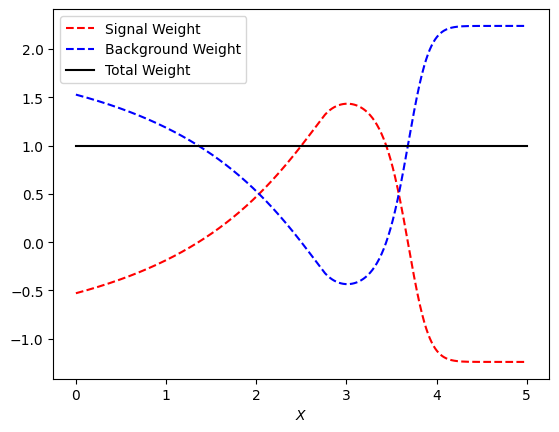

In [51]:
x=np.linspace(0,5,1000)
fig, ax = plt.subplots()
sw = sweighter_plot.get_weight(0,x)
bw = sweighter_plot.get_weight(1,x)
ax.plot(x, sw, 'r--', label='Signal Weight')
ax.plot(x, bw, 'b--', label='Background Weight')
ax.plot(x, sw+bw, 'k-', label='Total Weight')
ax.legend()
ax.set_xlabel('$X$')

Text(0.5, 0, '$Y$')

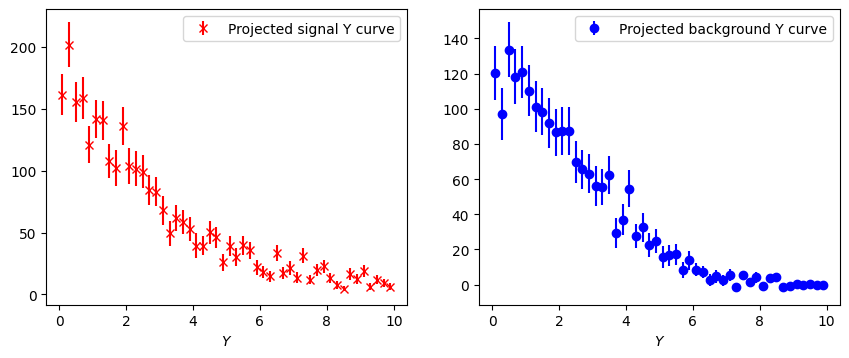

In [70]:
sw = sweighter.get_weight(0,x_arrays_dict[5000][0])
bw = sweighter.get_weight(1, x_arrays_dict[5000][0])

ysw, ye = np.histogram(y_arrays_dict[5000][0], bins=50, range=yrange, weights=sw )
ybw, ye = np.histogram( y_arrays_dict[5000][0], bins=50, range=yrange, weights=bw )

ysw2, ye = np.histogram(y_arrays_dict[5000][0], bins=50, range=yrange, weights=sw**2 )
ybw2, ye = np.histogram(y_arrays_dict[5000][0], bins=50, range=yrange, weights=bw**2 )

cy = 0.5*(ye[1:]+ye[:-1])

fig, ax = plt.subplots(1, 2, figsize=(0.8*12.8, 0.8*4.8))

ax[0].errorbar( cy, ysw, ysw2**0.5, fmt='rx', label='Projected signal Y curve' )
ax[0].legend()
ax[1].errorbar( cy, ybw, ybw2**0.5, fmt='bo', label='Projected background Y curve' )
ax[1].legend()

ax[0].set_xlabel('$Y$')
ax[1].set_xlabel('$Y$')


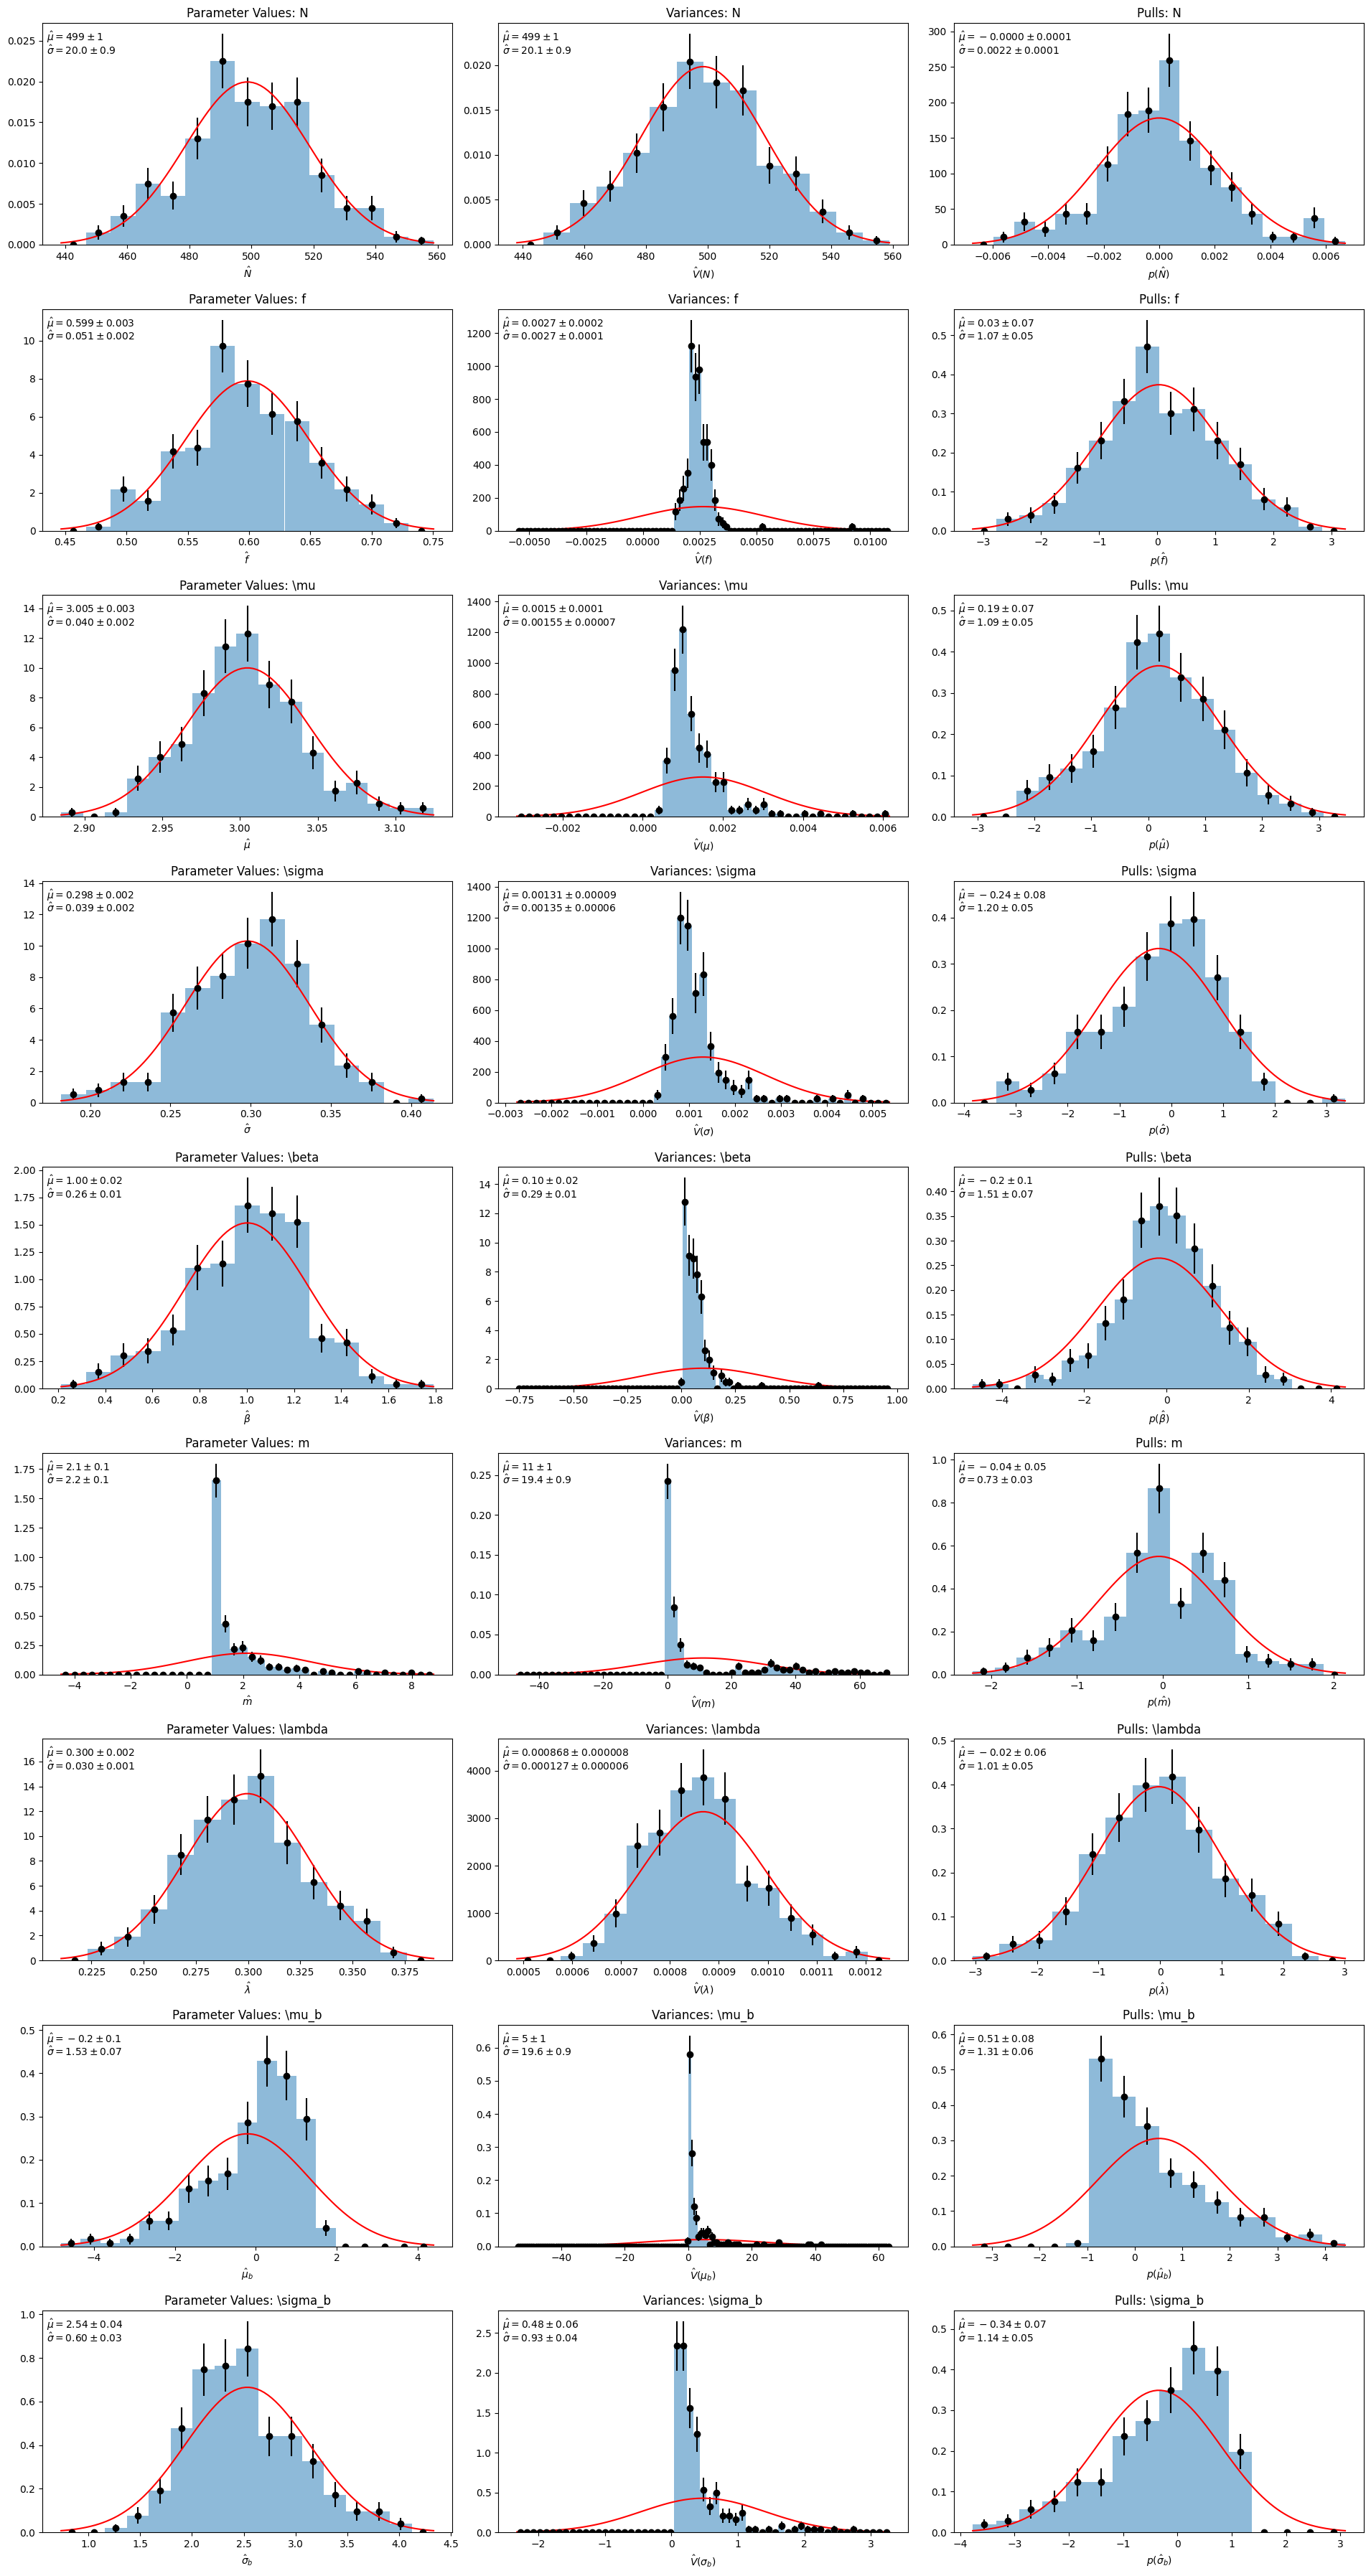

In [37]:
# Assuming param_names is defined
param_names = ['N', 'f', '\mu', '\sigma', '\\beta', 'm', '\lambda', '\mu_b', '\sigma_b']

# Extract data for the `500` key
values_500 = values[500]
errors_500 = errors[500]
pulls_500 = pulls[500]

# Create a grid with 8 rows (one per parameter) and 3 columns
fig, axes = plt.subplots(len(param_names), 3, figsize=(19.2, len(param_names) * 4))  

for i, name in enumerate(param_names):
    # LaTeX-friendly parameter name
    estname = f"\\hat{{{name.split('_')[0]}}}"  # Use double backslashes for LaTeX
    if len(name.split('_')) > 1:
        estname += '_' + name.split('_')[1]
    
    # Plot parameter values
    ax = axes[i, 0]
    plot(values_500[:, i], ax)
    ax.set_xlabel(f"${estname}$")
    ax.set_title(f"Parameter Values: {name}")

    # Plot variances (square of errors)
    ax = axes[i, 1]
    plot(errors_500[:, i]**2, ax)
    ax.set_xlabel(f"$\\hat{{V}}({name})$")
    ax.set_title(f"Variances: {name}")

    # Plot pulls
    ax = axes[i, 2]
    plot(pulls_500[:, i], ax)
    ax.set_xlabel(f"$p({estname})$")
    ax.set_title(f"Pulls: {name}")
    
# Adjust layout
plt.tight_layout()
plt.show()

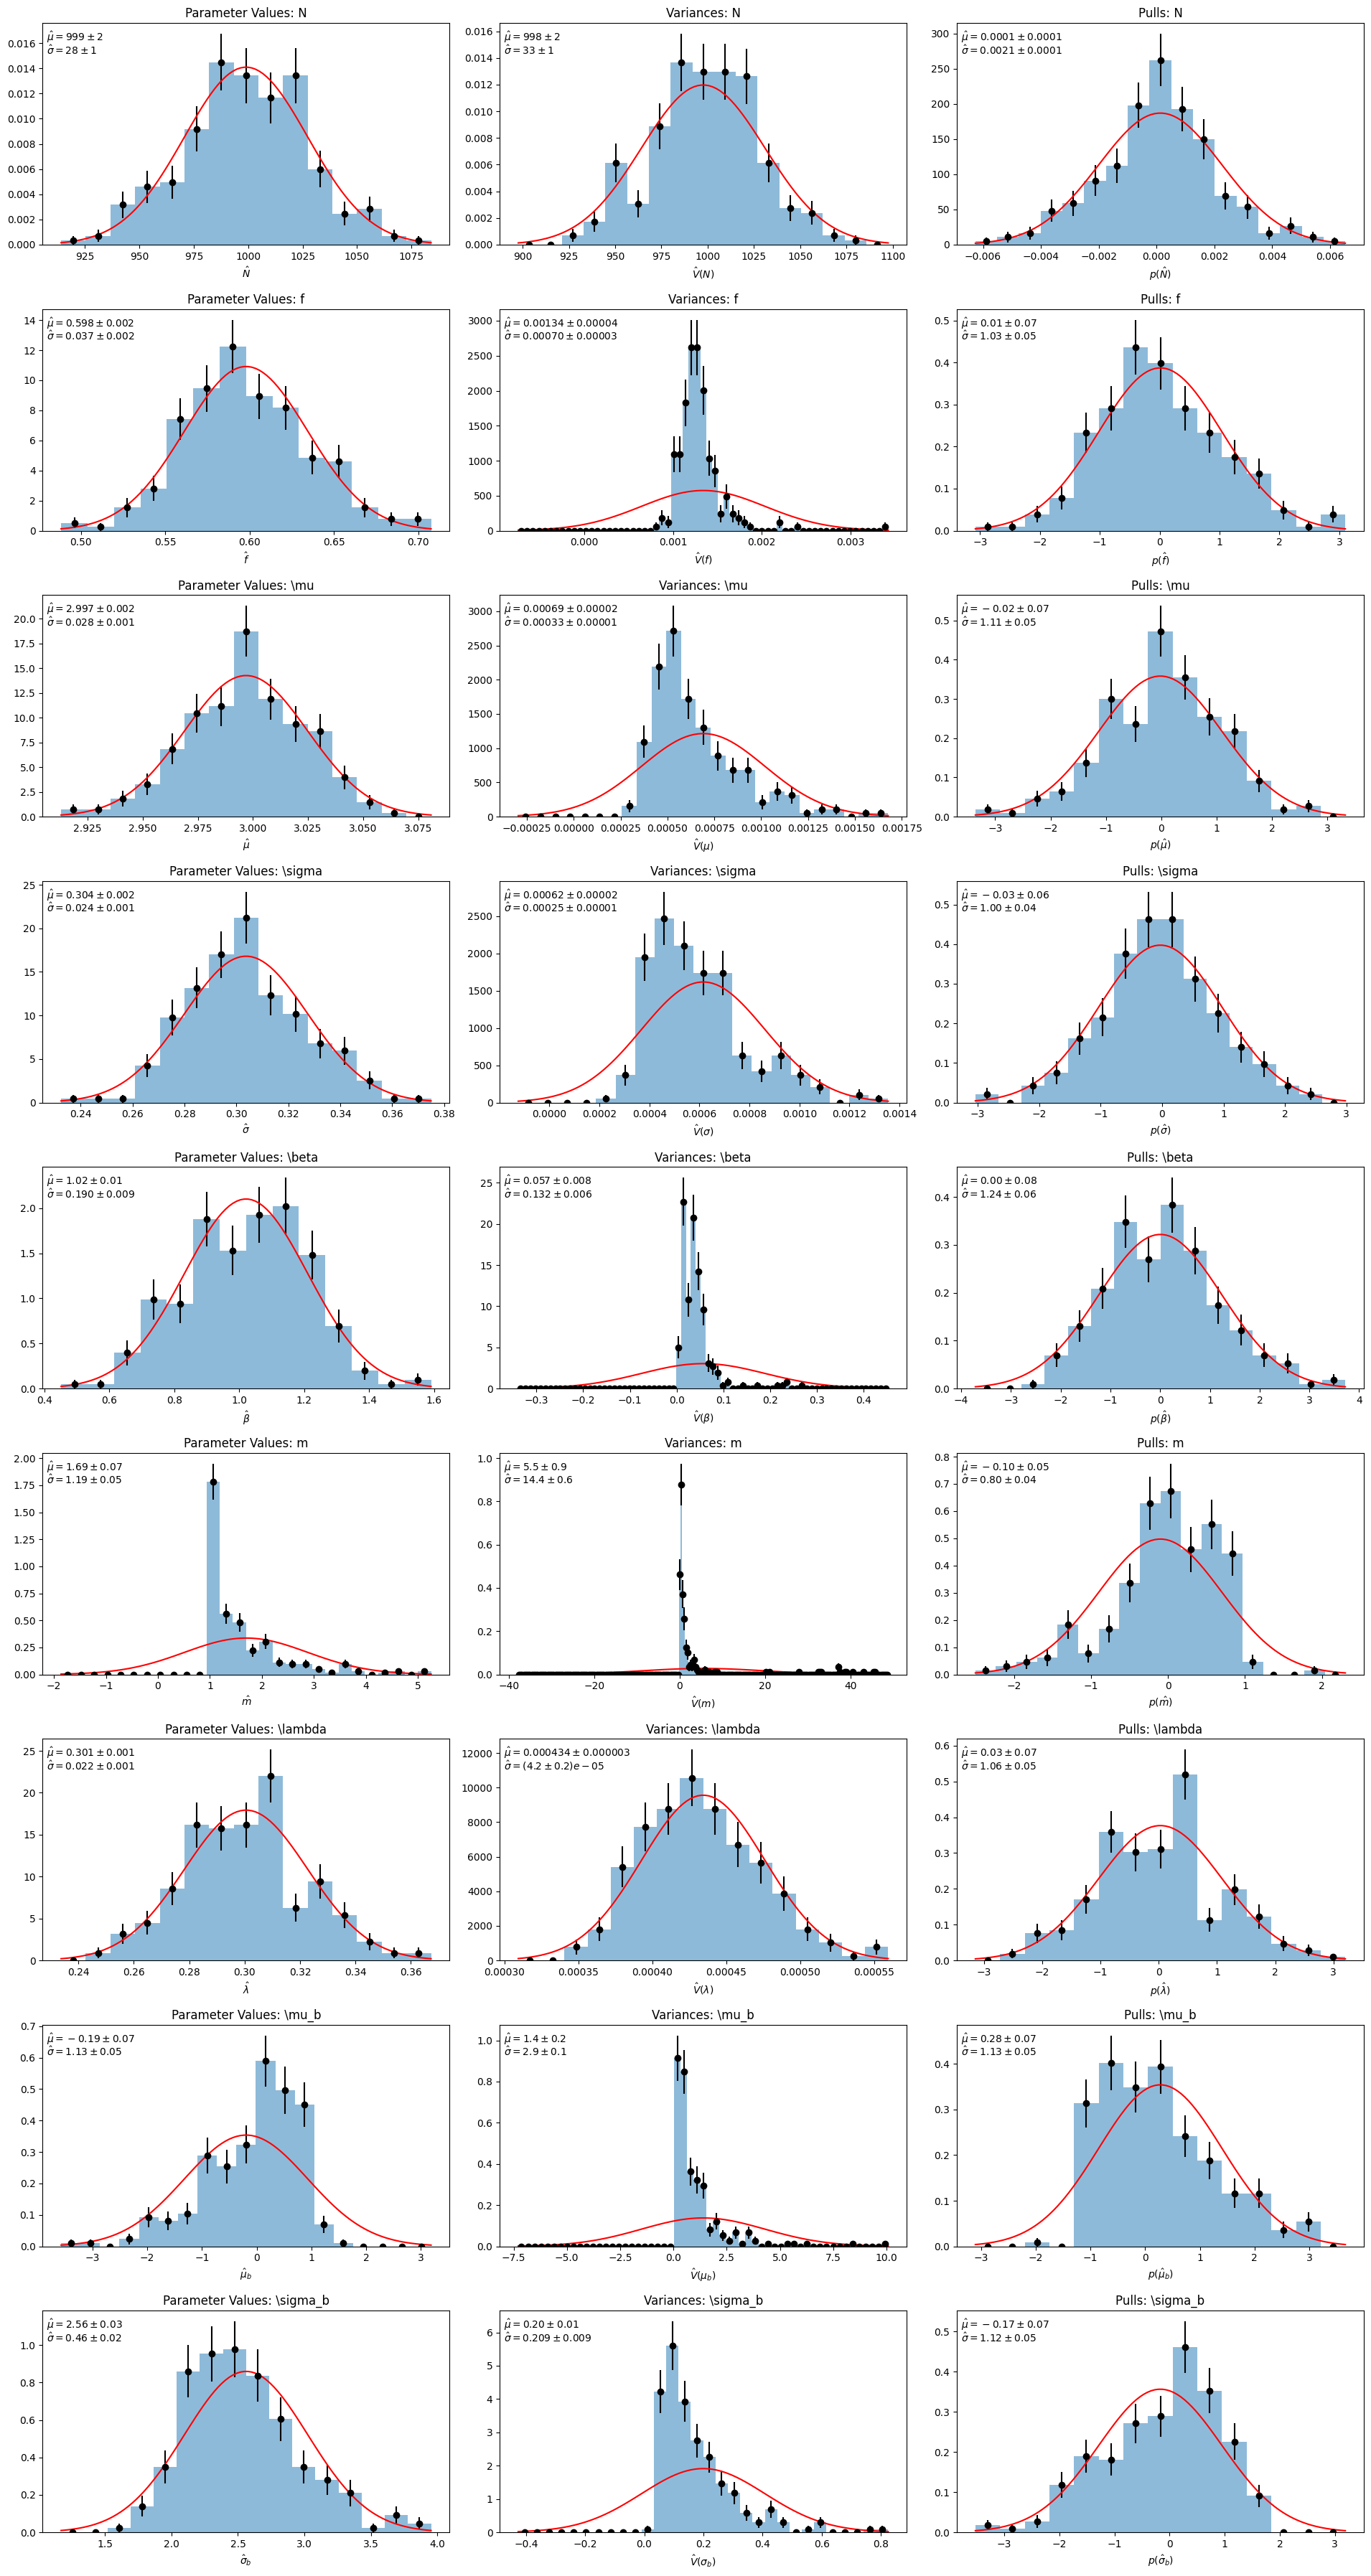

In [38]:
# Assuming param_names is defined
param_names = ['N', 'f', '\mu', '\sigma', '\\beta', 'm', '\lambda', '\mu_b', '\sigma_b']

# Extract data for the `500` key
values_1000 = values[1000]
errors_1000 = errors[1000]
pulls_1000 = pulls[1000]

# Create a grid with 8 rows (one per parameter) and 3 columns
fig, axes = plt.subplots(len(param_names), 3, figsize=(19.2, len(param_names) * 4))  

for i, name in enumerate(param_names):
    # LaTeX-friendly parameter name
    estname = f"\\hat{{{name.split('_')[0]}}}"  # Use double backslashes for LaTeX
    if len(name.split('_')) > 1:
        estname += '_' + name.split('_')[1]
    
    # Plot parameter values
    ax = axes[i, 0]
    plot(values_1000[:, i], ax)
    ax.set_xlabel(f"${estname}$")
    ax.set_title(f"Parameter Values: {name}")

    # Plot variances (square of errors)
    ax = axes[i, 1]
    plot(errors_1000[:, i]**2, ax)
    ax.set_xlabel(f"$\\hat{{V}}({name})$")
    ax.set_title(f"Variances: {name}")

    # Plot pulls
    ax = axes[i, 2]
    plot(pulls_1000[:, i], ax)
    ax.set_xlabel(f"$p({estname})$")
    ax.set_title(f"Pulls: {name}")
    
# Adjust layout
plt.tight_layout()
plt.show()

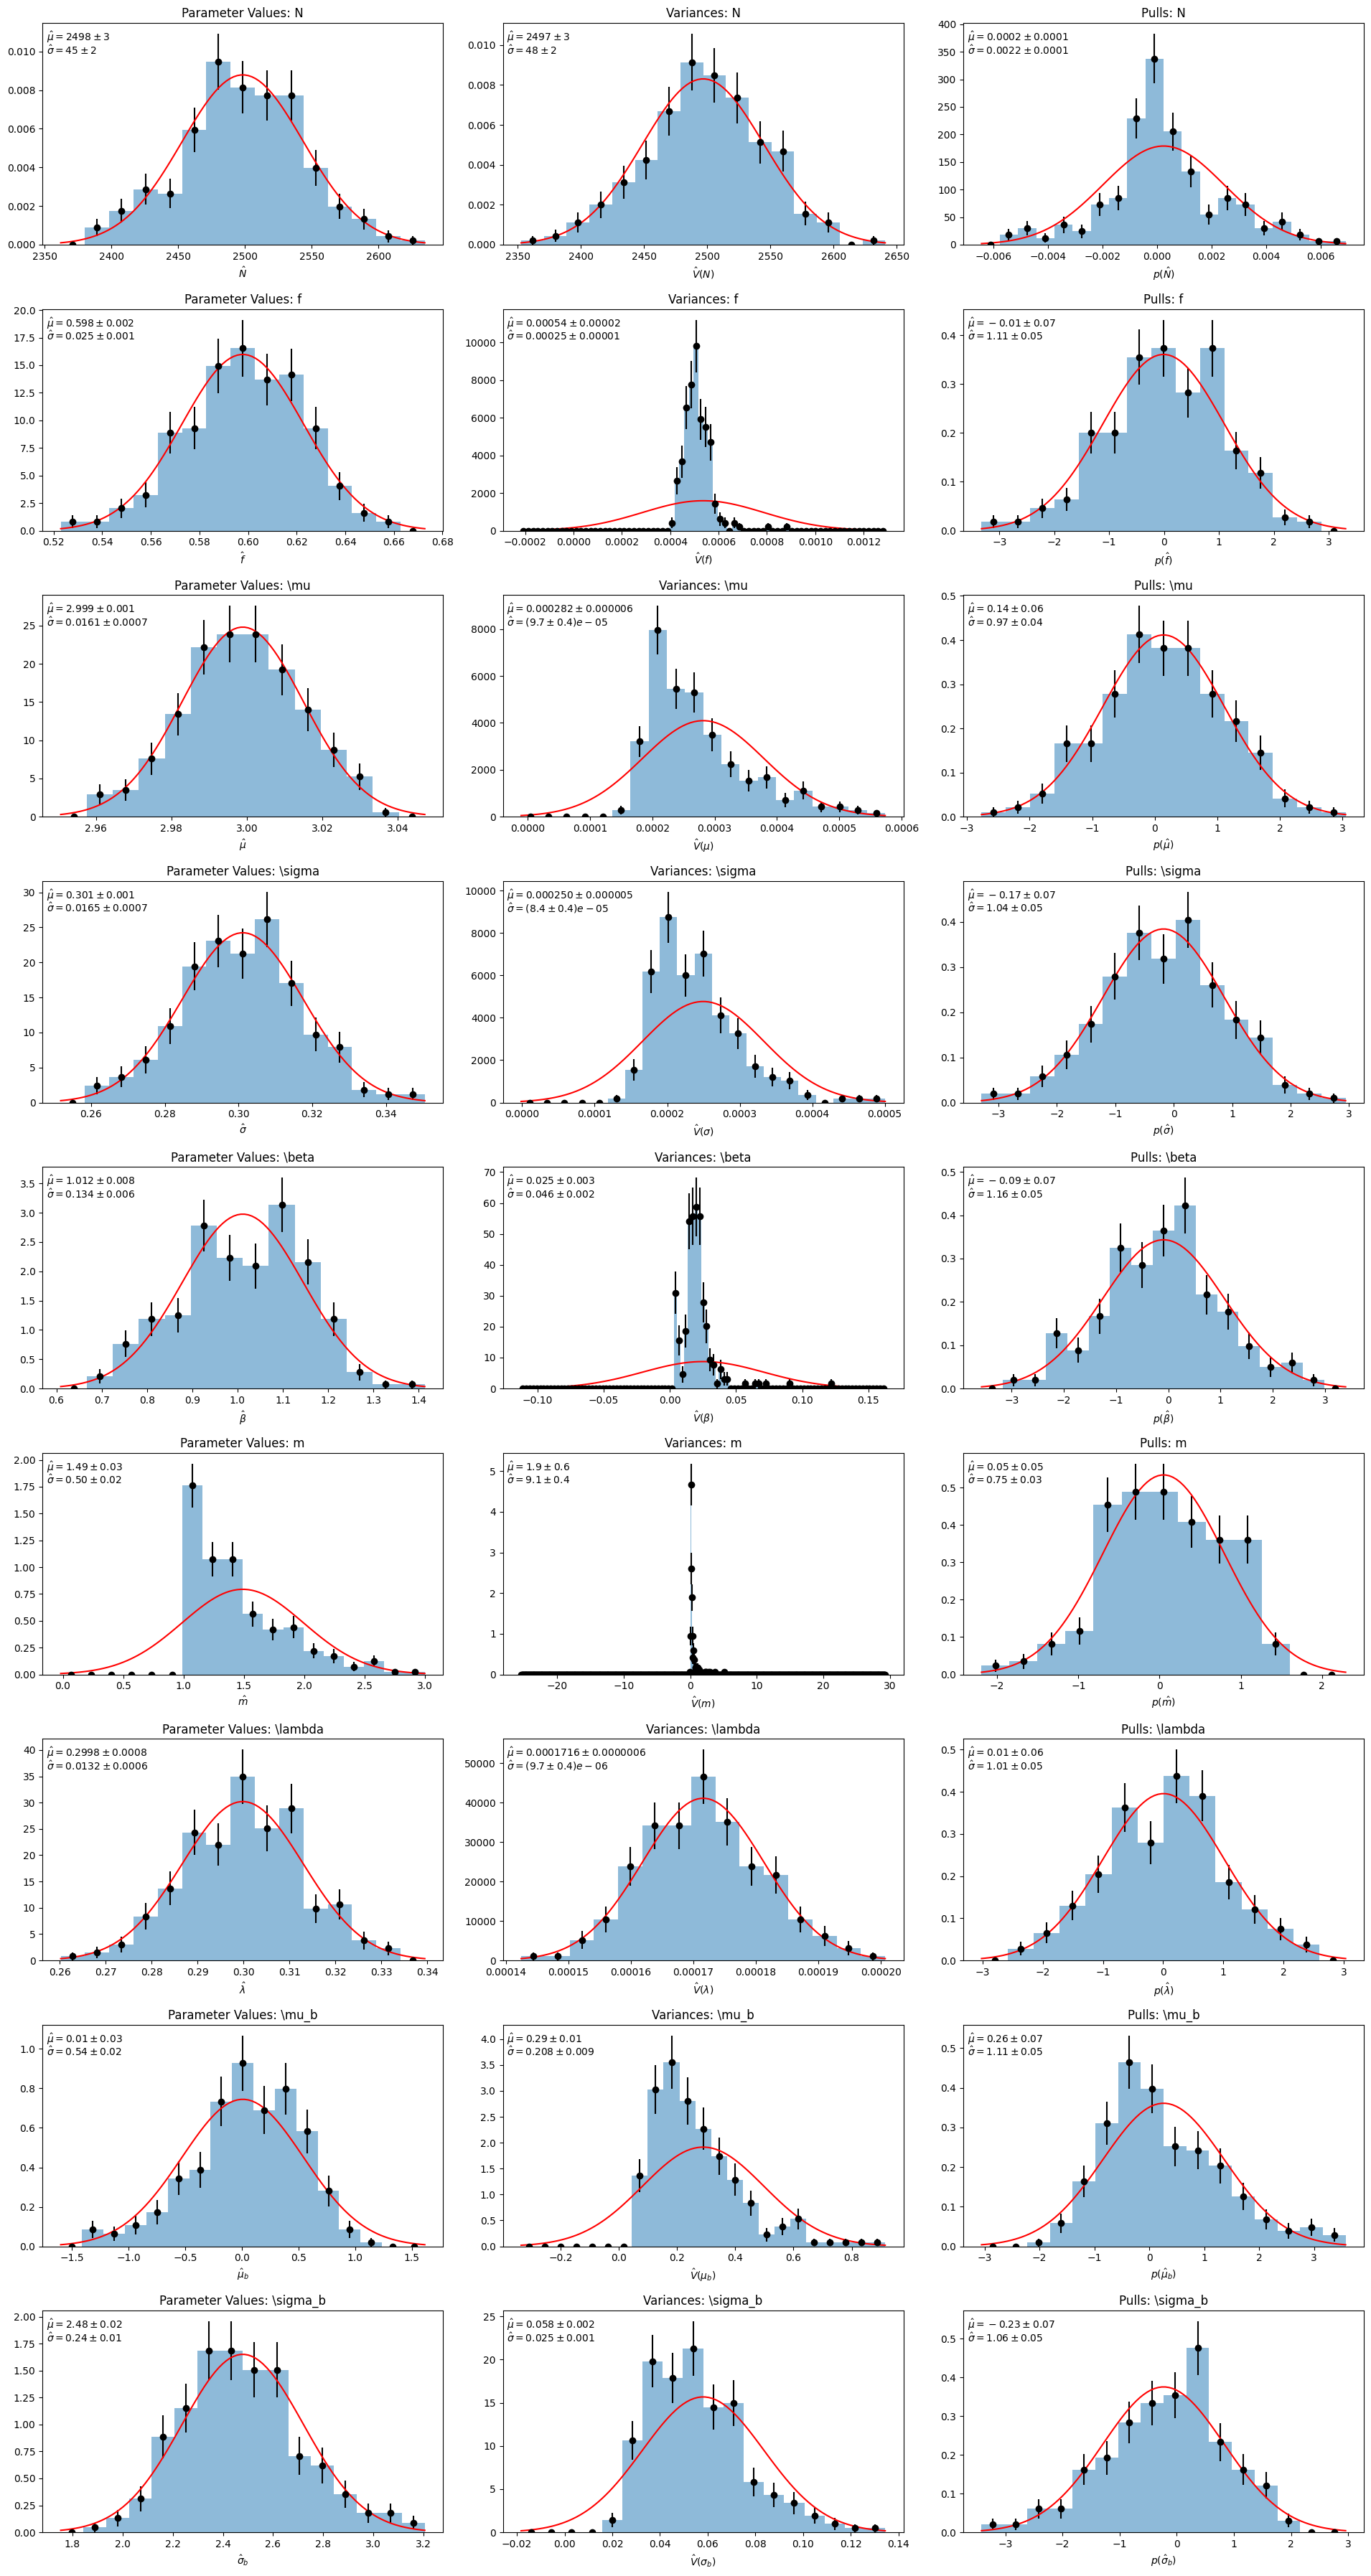

In [39]:
# Assuming param_names is defined
param_names = ['N', 'f', '\mu', '\sigma', '\\beta', 'm', '\lambda', '\mu_b', '\sigma_b']

# Extract data for the `500` key
values_2500 = values[2500]
errors_2500 = errors[2500]
pulls_2500 = pulls[2500]

# Create a grid with 8 rows (one per parameter) and 3 columns
fig, axes = plt.subplots(len(param_names), 3, figsize=(19.2, len(param_names) * 4))  

for i, name in enumerate(param_names):
    # LaTeX-friendly parameter name
    estname = f"\\hat{{{name.split('_')[0]}}}"  # Use double backslashes for LaTeX
    if len(name.split('_')) > 1:
        estname += '_' + name.split('_')[1]
    
    # Plot parameter values
    ax = axes[i, 0]
    plot(values_2500[:, i], ax)
    ax.set_xlabel(f"${estname}$")
    ax.set_title(f"Parameter Values: {name}")

    # Plot variances (square of errors)
    ax = axes[i, 1]
    plot(errors_2500[:, i]**2, ax)
    ax.set_xlabel(f"$\\hat{{V}}({name})$")
    ax.set_title(f"Variances: {name}")

    # Plot pulls
    ax = axes[i, 2]
    plot(pulls_2500[:, i], ax)
    ax.set_xlabel(f"$p({estname})$")
    ax.set_title(f"Pulls: {name}")
    
# Adjust layout
plt.tight_layout()
plt.show()

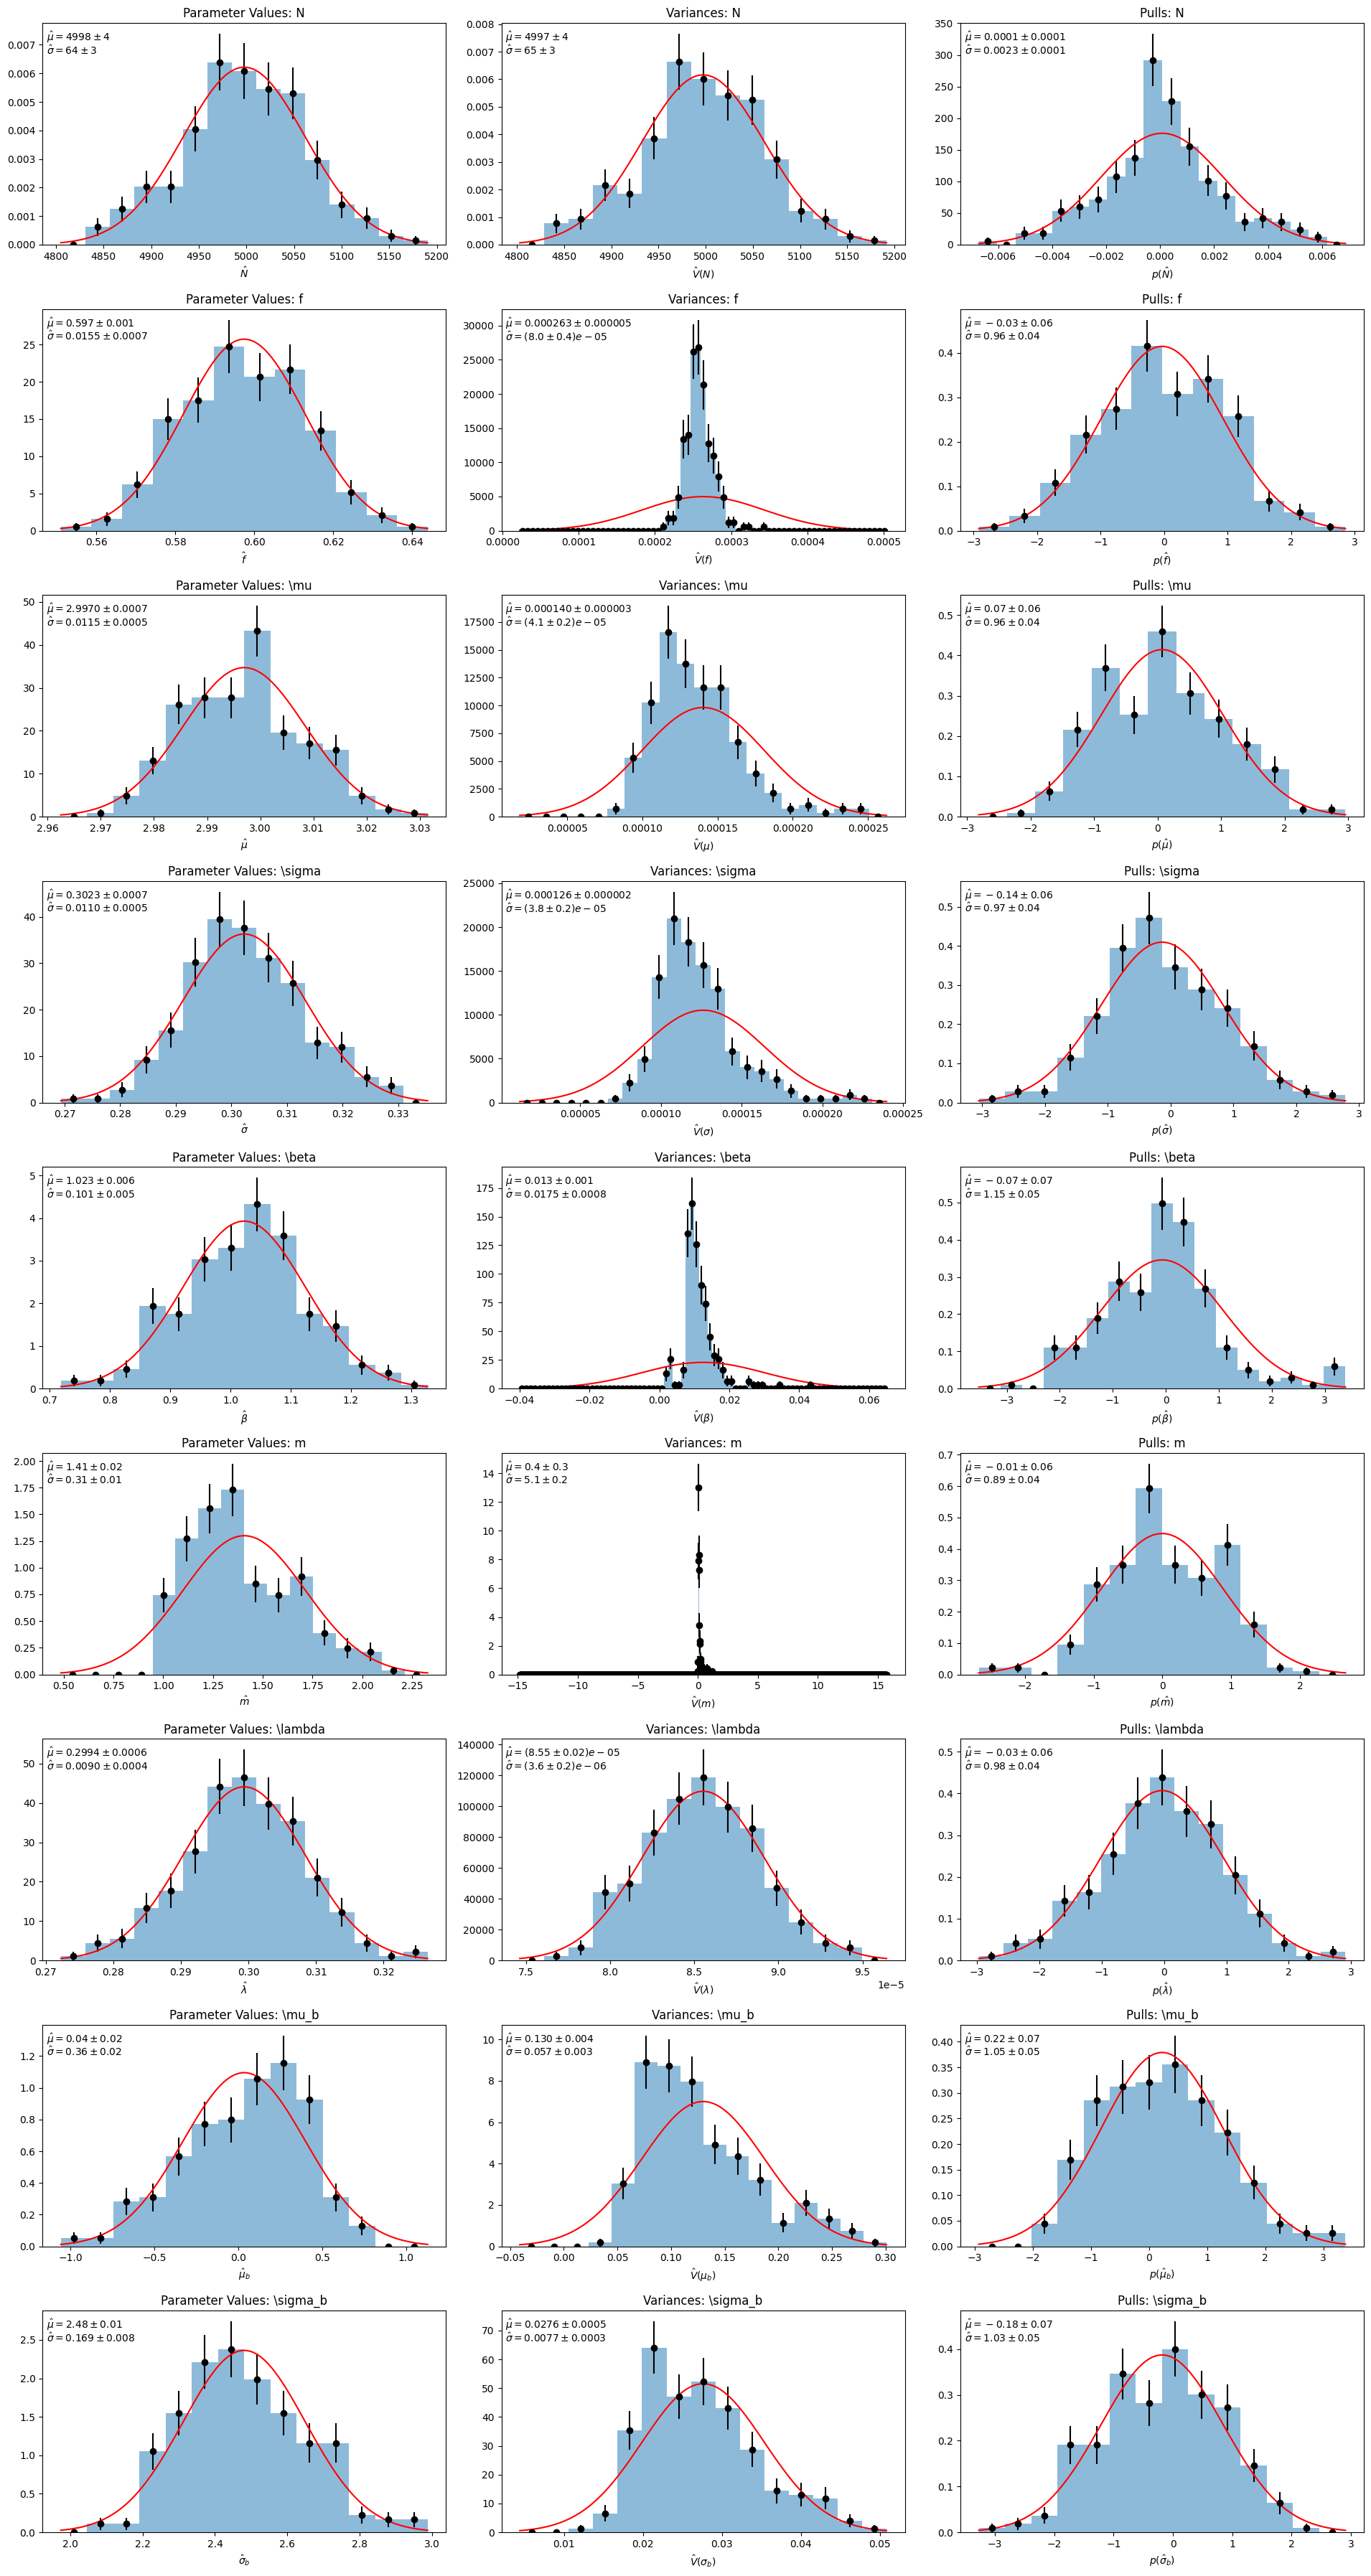

In [40]:
# Assuming param_names is defined
param_names = ['N', 'f', '\mu', '\sigma', '\\beta', 'm', '\lambda', '\mu_b', '\sigma_b']

# Extract data for the `500` key
values_5000 = values[5000]
errors_5000 = errors[5000]
pulls_5000 = pulls[5000]

# Create a grid with 8 rows (one per parameter) and 3 columns
fig, axes = plt.subplots(len(param_names), 3, figsize=(19.2, len(param_names) * 4))  

for i, name in enumerate(param_names):
    # LaTeX-friendly parameter name
    estname = f"\\hat{{{name.split('_')[0]}}}"  # Use double backslashes for LaTeX
    if len(name.split('_')) > 1:
        estname += '_' + name.split('_')[1]
    
    # Plot parameter values
    ax = axes[i, 0]
    plot(values_5000[:, i], ax)
    ax.set_xlabel(f"${estname}$")
    ax.set_title(f"Parameter Values: {name}")

    # Plot variances (square of errors)
    ax = axes[i, 1]
    plot(errors_5000[:, i]**2, ax)
    ax.set_xlabel(f"$\\hat{{V}}({name})$")
    ax.set_title(f"Variances: {name}")

    # Plot pulls
    ax = axes[i, 2]
    plot(pulls_5000[:, i], ax)
    ax.set_xlabel(f"$p({estname})$")
    ax.set_title(f"Pulls: {name}")
    
# Adjust layout
plt.tight_layout()
plt.show()

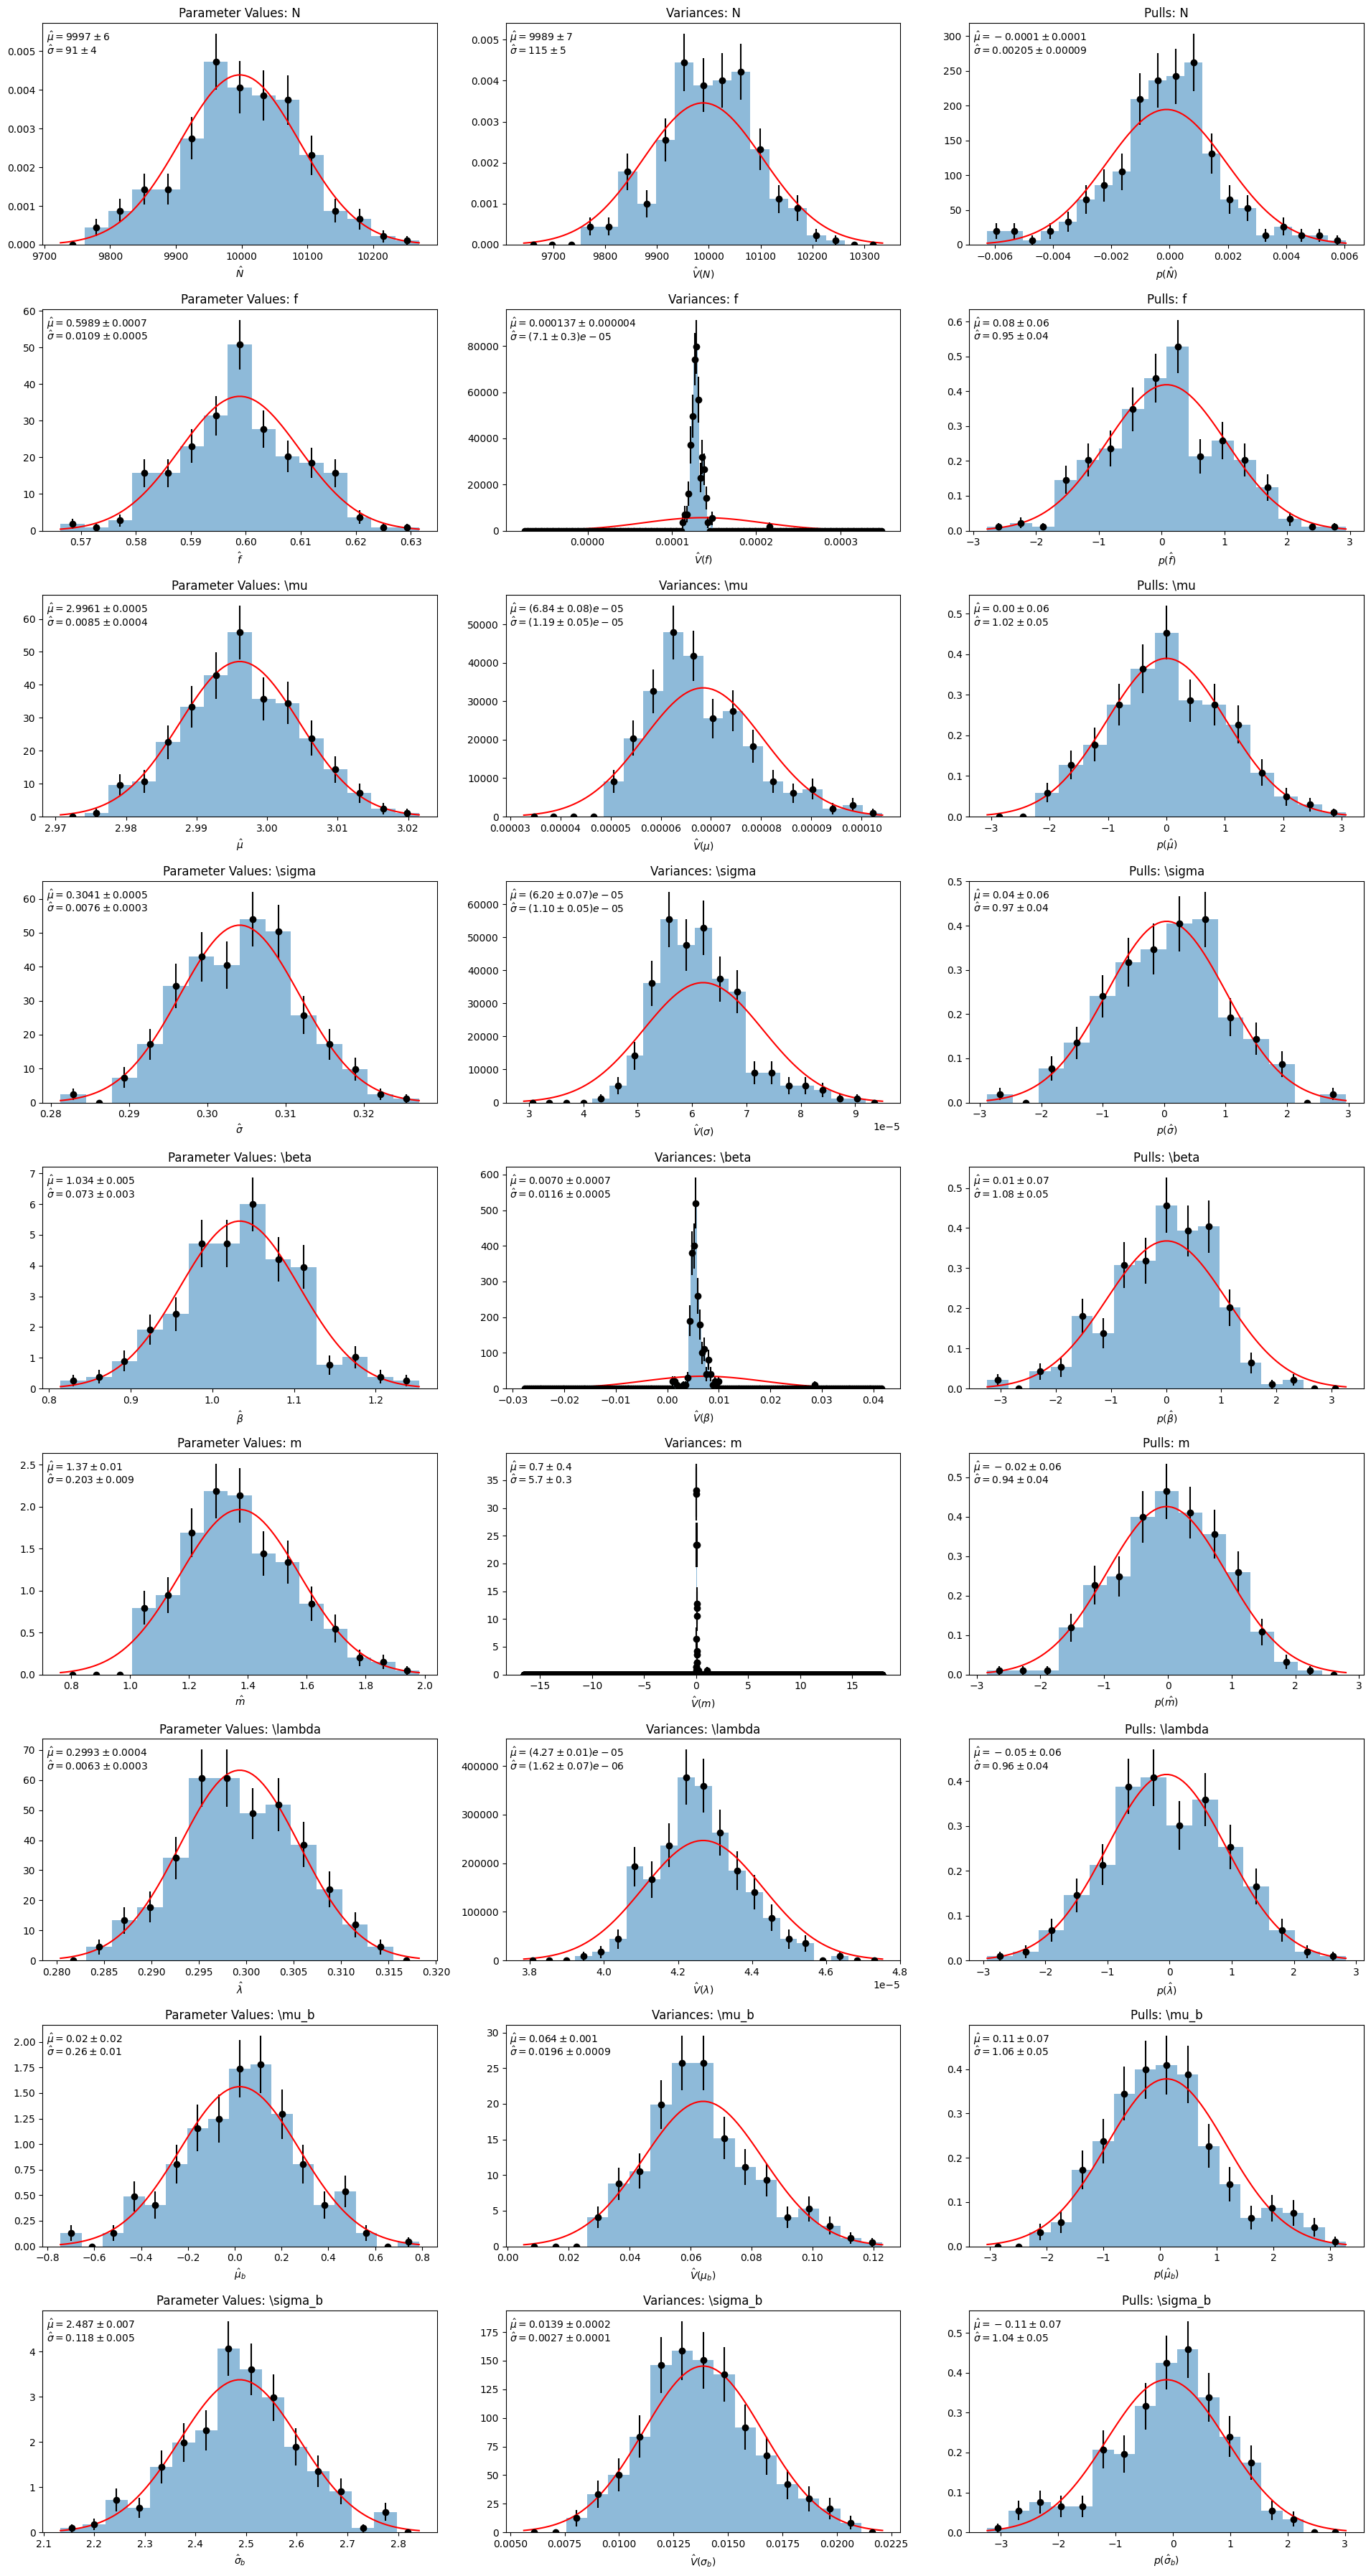

In [41]:
# Assuming param_names is defined
param_names = ['N', 'f', '\mu', '\sigma', '\\beta', 'm', '\lambda', '\mu_b', '\sigma_b']

# Extract data for the `500` key
values_10000 = values[10000]
errors_10000 = errors[10000]
pulls_10000 = pulls[10000]

# Create a grid with 8 rows (one per parameter) and 3 columns
fig, axes = plt.subplots(len(param_names), 3, figsize=(19.2, len(param_names) * 4))  

for i, name in enumerate(param_names):
    # LaTeX-friendly parameter name
    estname = f"\\hat{{{name.split('_')[0]}}}"  # Use double backslashes for LaTeX
    if len(name.split('_')) > 1:
        estname += '_' + name.split('_')[1]
    
    # Plot parameter values
    ax = axes[i, 0]
    plot(values_10000[:, i], ax)
    ax.set_xlabel(f"${estname}$")
    ax.set_title(f"Parameter Values: {name}")

    # Plot variances (square of errors)
    ax = axes[i, 1]
    plot(errors_10000[:, i]**2, ax)
    ax.set_xlabel(f"$\\hat{{V}}({name})$")
    ax.set_title(f"Variances: {name}")

    # Plot pulls
    ax = axes[i, 2]
    plot(pulls_10000[:, i], ax)
    ax.set_xlabel(f"$p({estname})$")
    ax.set_title(f"Pulls: {name}")
    
# Adjust layout
plt.tight_layout()
plt.show()